# **ARTIFICIAL INTELLIGENCE & MACHINE LEARNING PROJECT**
### Designed and coded by: Federico Pallesi, Riccardo Baldini, Andrea Goberti

Our dataset, *"Aerogel Bonding"*, contains diverse data on bonding processes and factors influencing their success. Our goal is to understand why certain processes and conditions lead to successful bonding, enabling us to improve efficiency, promote high-quality production outcomes, and optimize bonding strategies. From this description, it is evident that we are dealing with a **Classification** problem to identify patterns and categorize different bonding scenarios.


We start this long journey by importing the dataset using *Pandas* library.
We then display a sample of the dataset in order to understand how it's structured.

In [249]:
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

ds = pd.read_csv('aerogel_bonding.csv')
ds.sample(5, random_state=42)

HolidaysTaken  PercentageOfCompletedTasks  CurrentJobDuration  \
10650            0.0                    0.408910                 5.0   
2041             4.0                    0.215269                 8.0   
8668             5.0                    0.057655                 3.0   
1114             2.0                    0.084179                 5.0   
13902            2.0                    0.086089                 NaN   

       RecentHolidaysTaken  RequestedProcessAmount      JobStatus  \
10650                  0.0                 35577.0       Employed   
2041                   1.0                     NaN       Employed   
8668                   1.0                 18233.0  Self-Employed   
1114                   0.0                 13971.0       Employed   
13902                  1.0                 38847.0       Employed   

       BondingRiskRating  TotalMaterialProcessed  ByproductRation  \
10650               53.0                 23688.0         0.218621   
2041                51.0                 67956.0         0.446476   
8668                56.0                 40542.0         0.328947   
1114                57.0                 35789.0         0.463089   
13902               54.0                 56237.0         0.220161   

       working_skills  ... TotalMaterialToProcess  WorkHistoryDuration  \
10650        1.513446  ...                10600.0                  NaN   
2041         4.536211  ...                 2583.0                 19.0   
8668         2.104998  ...                12831.0                 13.0   
1114         1.964776  ...                15223.0                  8.0   
13902             NaN  ...                    NaN                  6.0   

       ApplicantAge PriorExecutionDefaults  DifferentTasksCompleted  \
10650          41.0                    0.0                      1.0   
2041           35.0                    0.0                      1.0   
8668           53.0                    0.0                      1.0   
1114            NaN                    0.0                      3.0   
13902          38.0                    0.0                      1.0   

       TotalChurnRisk  OtherCompaniesMaterialProcessed  BondingPeriod  \
10650             NaN                          13088.0           24.0   
2041         0.248627                          65373.0           60.0   
8668         0.244147                          27711.0            NaN   
1114         0.176777                          20566.0           48.0   
13902        0.273237                           5534.0           72.0   

      trustability  MonthlyExecutions  
10650     3.527723              386.0  
2041      2.042271                NaN  
8668      2.810025              548.0  
1114      2.657860              254.0  
13902     3.342685              402.0  

[5 rows x 31 columns]

# 1. EXPLORATORY DATA ANALYSIS <br>
EDA serves as a crucial initial step in any data-driven project, allowing analysts to uncover patterns, detect anomalies, and gain insights into the structure and relationships within the dataset. Through EDA, we can identify key variables, assess data quality, and lay the foundations for effective modeling and decision-making.

## 1.1 Missing values <br>
We want to check right away what the situation with missing values is, displaying the total number per variable with its percentage and the heatmap.


In [250]:
missing_count = ds.isnull().sum()
missing_percentage = (ds.isnull().sum() / len(ds)) * 100

missing_summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage (%)': missing_percentage.round(0).astype(int)
})

print(missing_summary)

                                 Missing Count  Missing Percentage (%)
HolidaysTaken                             1905                      10
PercentageOfCompletedTasks                2045                      10
CurrentJobDuration                        2048                      10
RecentHolidaysTaken                       1969                      10
RequestedProcessAmount                    2075                      10
JobStatus                                 2018                      10
BondingRiskRating                         2050                      10
TotalMaterialProcessed                    2043                      10
ByproductRation                           1972                      10
working_skills                            1966                      10
CivilStatus                               1954                      10
dependability                             1949                      10
MistakesLastYear                          1987                      10
Highes

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 800x400 with 0 Axes>

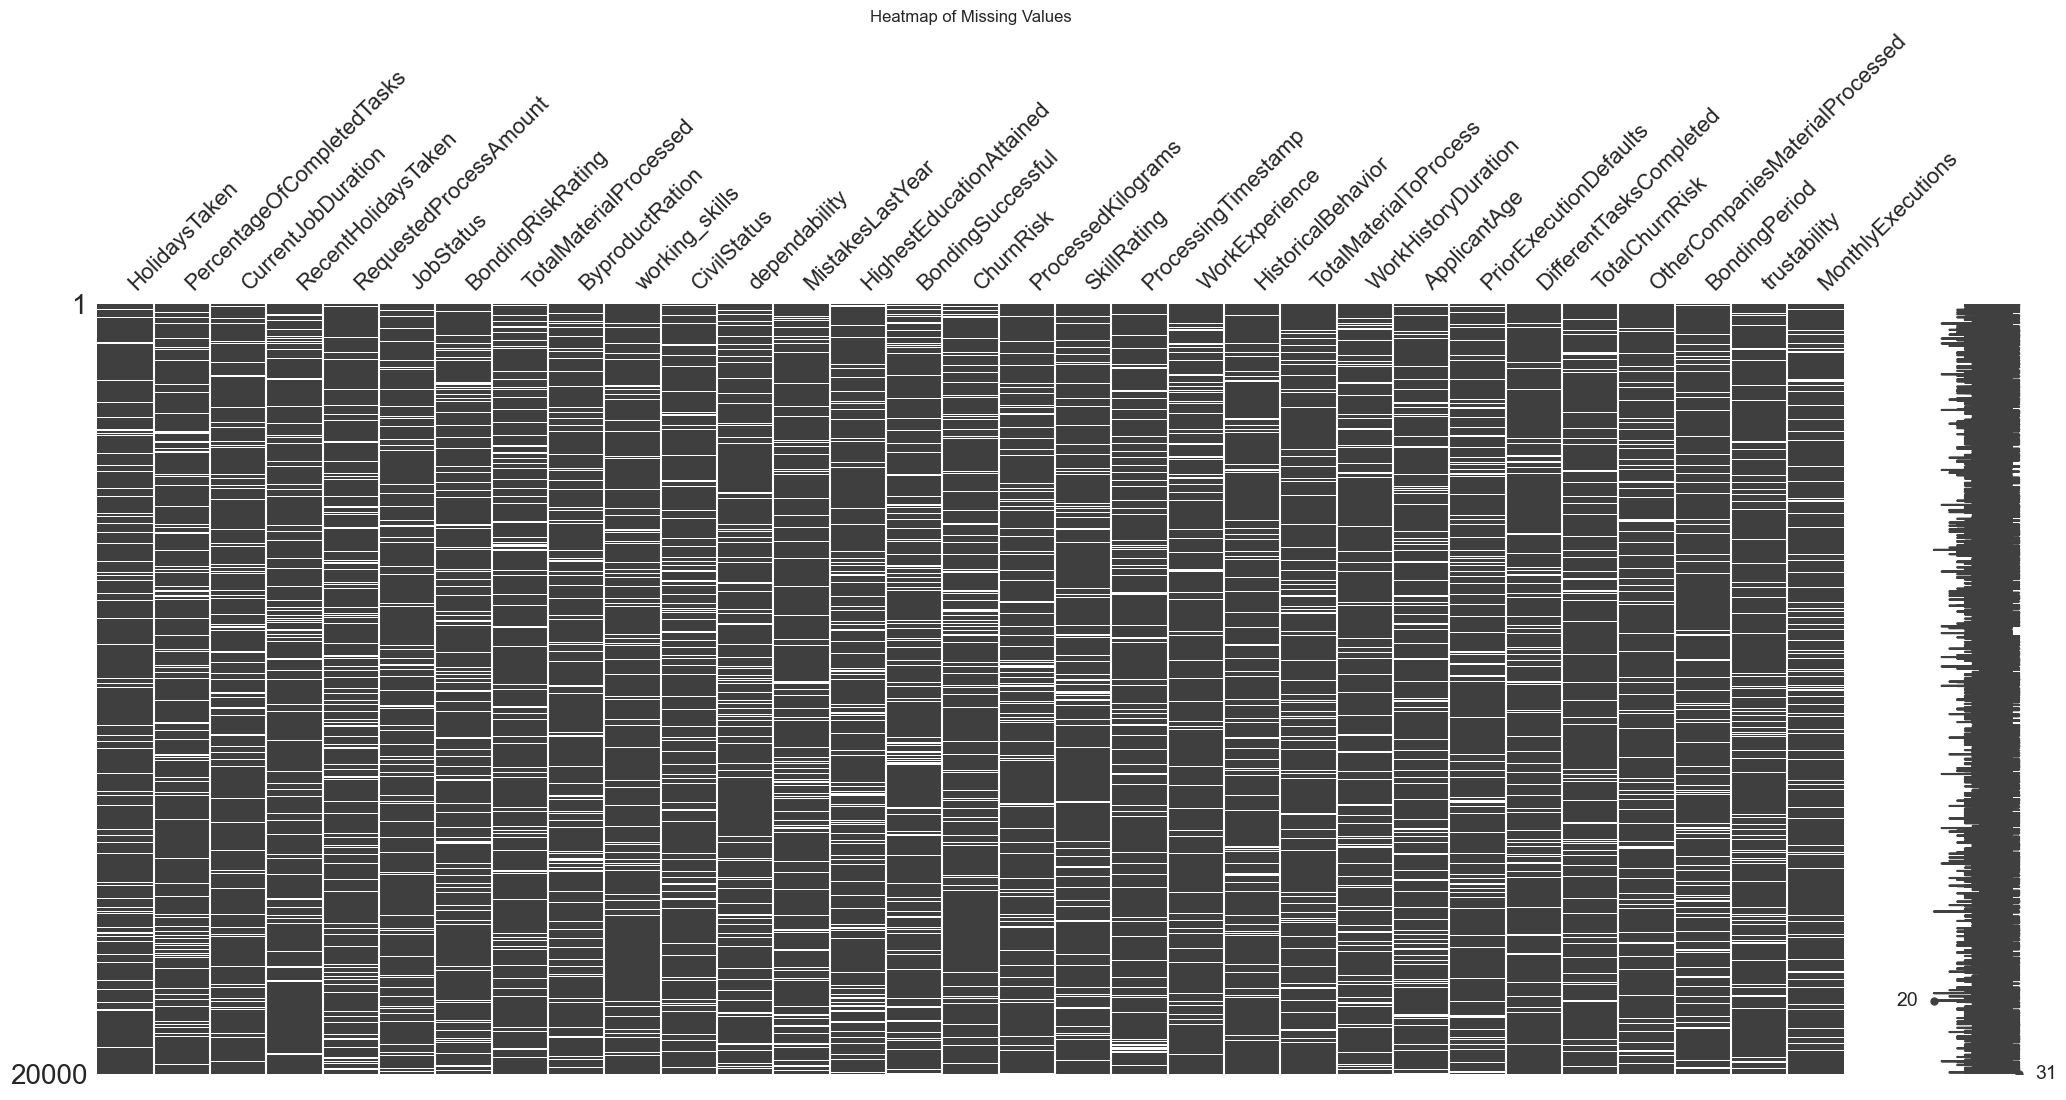

In [251]:
plt.figure(figsize=(8,4))
msno.matrix(ds)
plt.title('Heatmap of Missing Values')
plt.show

The dataset contains a notable proportion of missing values across several columns. We also notice that the missing values are evenly spread across all variables. <br>
Nonetheless, we can infere that some missing values might not be random. For instance:
- Missing data in `RequestedProcessAmount` could relate to incomplete processing records
- Missing data in `BondingRiskRating` could indicate unassessed processes

These missing values will be imputed later to ensure accurate analysis and maintain the integrity of the insights derived. 

## 1.2 Outliers detection

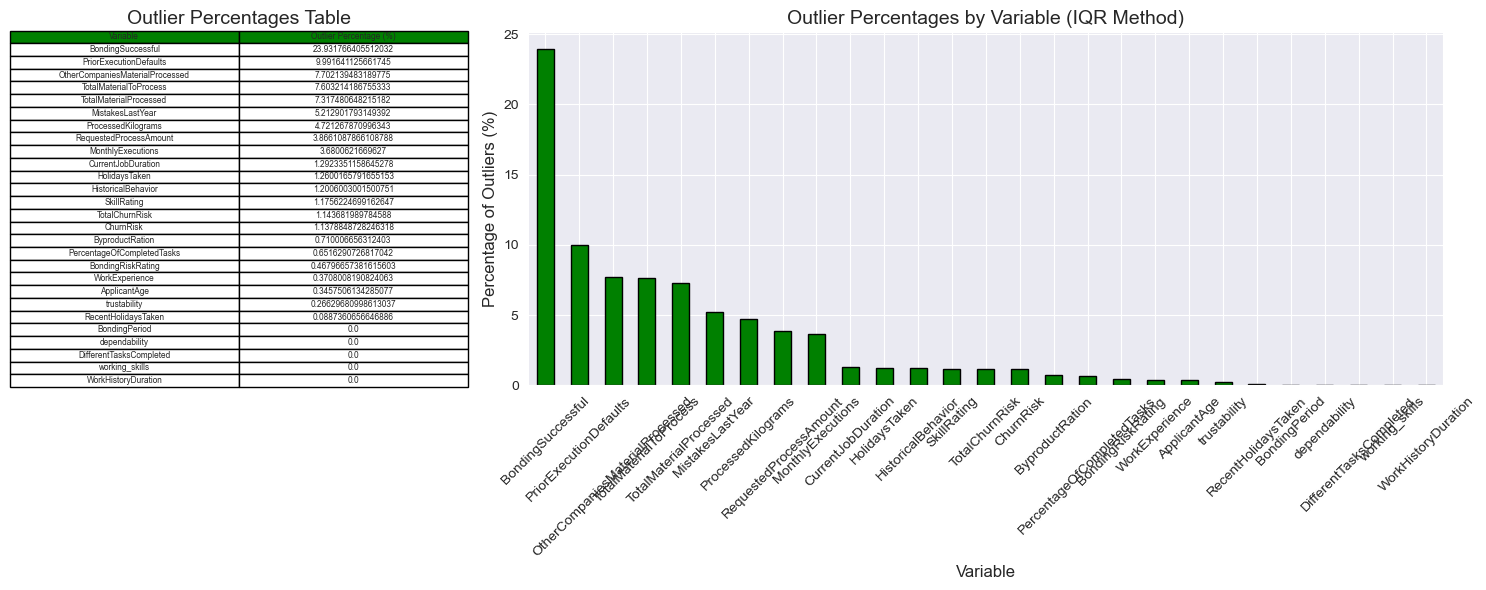

In [252]:
numeric_columns = ds.select_dtypes(include=['float64', 'int64']).columns

# Define using the IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = data[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR 
    return (data[column] < lower_bound) | (data[column] > upper_bound)

# Apply method to each numeric column
iqr_outliers = pd.DataFrame({col: detect_outliers_iqr(ds, col) for col in numeric_columns})

# Count the number of outliers for each column
iqr_outlier_counts = iqr_outliers.sum()
total_data_points = ds[numeric_columns].notnull().sum()

# Calculate the percentage of outliers for each numeric column
iqr_outlier_percentage = (iqr_outlier_counts / total_data_points) * 100

# Sort the outlier percentages in descending order
iqr_outlier_percentage_sorted = iqr_outlier_percentage.sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 2]})

# Display the outlier percentages
axes[0].axis('off')
table_data = iqr_outlier_percentage_sorted.reset_index()
axes[0].table(cellText=table_data.values, colLabels=["Variable", "Outlier Percentage (%)"],
              cellLoc='center', loc='center', colColours=["green"] * 2)
axes[0].set_title("Outlier Percentages Table", fontsize=14)

# Plot the outlier percentages
iqr_outlier_percentage_sorted.plot(kind='bar', color='green', edgecolor='black', ax=axes[1])
axes[1].set_title('Outlier Percentages by Variable (IQR Method)', fontsize=14)
axes[1].set_xlabel('Variable', fontsize=12)
axes[1].set_ylabel('Percentage of Outliers (%)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


The InterQuartile Range method revealed the presence of quite some outliers, especially in our target variable `BondingSuccessful`.
A first approach would be to remove these anomalies only from the target variable, but at second thought, we decide not to and here's why:
1. It could possibly lead to incomplete treatment, affecting model training
2. It could distort the relationship between predictors and the target, especially in a classification problem

A second approach would be to choose models robust enough not to be affected by outliers, and this is the one we opt for.

Therefore, you will not find any outlier removal within our project.

## 1.3 Descriptive statistical data analysis

In [253]:
ds.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   HolidaysTaken                    18095 non-null  float64
 1   PercentageOfCompletedTasks       17955 non-null  float64
 2   CurrentJobDuration               17952 non-null  float64
 3   RecentHolidaysTaken              18031 non-null  float64
 4   RequestedProcessAmount           17925 non-null  float64
 5   JobStatus                        17982 non-null  object 
 6   BondingRiskRating                17950 non-null  float64
 7   TotalMaterialProcessed           17957 non-null  float64
 8   ByproductRation                  18028 non-null  float64
 9   working_skills                   18034 non-null  float64
 10  CivilStatus                      18046 non-null  object 
 11  dependability                    18051 non-null  float64
 12  MistakesLastYear  

We notice pleasantly that our dataset contains only 4 categorical variables. The presence of these can sometimes be harmful for the correct execution of machine learning models, especially when dealing with a classification problem. Therefore these variables will be encoded when processing data.

We can see all the statistical information for every feature and the target column below:

In [254]:
ds.describe().T

count          mean            std  \
HolidaysTaken                    18095.0      3.026748       1.735829   
PercentageOfCompletedTasks       17955.0      0.285759       0.159537   
CurrentJobDuration               17952.0      5.009693       2.241757   
RecentHolidaysTaken              18031.0      0.994454       0.988381   
RequestedProcessAmount           17925.0  24897.926750   13437.679650   
BondingRiskRating                17950.0     50.762841       7.773452   
TotalMaterialProcessed           17957.0  96722.908114  121162.137838   
ByproductRation                  18028.0      0.286063       0.159942   
working_skills                   18034.0      2.360612       0.991873   
dependability                    18051.0      2.374670       0.988894   
MistakesLastYear                 18013.0      0.052129       0.222293   
BondingSuccessful                17997.0      0.239318       0.426679   
ChurnRisk                        17928.0      0.239193       0.035545   
ProcessedKilograms               18046.0  59189.375651   40340.017213   
SkillRating                      18033.0    571.738479      50.955495   
WorkExperience                   18069.0     17.466379      11.314968   
HistoricalBehavior               17991.0     24.015730       4.953001   
TotalMaterialToProcess           18045.0  36259.839014   47430.858935   
WorkHistoryDuration              17998.0     14.935271       8.374611   
ApplicantAge                     17932.0     39.765391      11.636018   
PriorExecutionDefaults           17945.0      0.099916       0.299897   
DifferentTasksCompleted          18049.0      1.512494       1.386266   
TotalChurnRisk                   18012.0      0.239262       0.042192   
OtherCompaniesMaterialProcessed  17995.0  71895.696360  115288.016159   
BondingPeriod                    17956.0     54.048786      24.696770   
trustability                     18025.0      2.267341       0.984234   
MonthlyExecutions                18016.0    454.077875     240.438963   

                                          min           25%           50%  \
HolidaysTaken                        0.000000      2.000000      3.000000   
PercentageOfCompletedTasks           0.000974      0.160089      0.266699   
CurrentJobDuration                   0.000000      3.000000      5.000000   
RecentHolidaysTaken                  0.000000      0.000000      1.000000   
RequestedProcessAmount            3674.000000  15607.000000  21916.000000   
BondingRiskRating                   28.800000     46.000000     52.000000   
TotalMaterialProcessed            2098.000000  31031.000000  60628.000000   
ByproductRation                      0.001720      0.161822      0.264880   
working_skills                       0.000000      1.679249      2.363138   
dependability                        0.000000      1.693475      2.376003   
MistakesLastYear                     0.000000      0.000000      0.000000   
BondingSuccessful                    0.000000      0.000000      0.000000   
ChurnRisk                            0.130101      0.213940      0.236365   
ProcessedKilograms               15000.000000  31686.750000  48604.500000   
SkillRating                        362.000000    540.000000    578.000000   
WorkExperience                       0.000000      9.000000     17.000000   
HistoricalBehavior                   8.000000     21.000000     24.000000   
TotalMaterialToProcess             372.000000  11205.000000  22185.000000   
WorkHistoryDuration                  1.000000      8.000000     15.000000   
ApplicantAge                        18.000000     32.000000     40.000000   
PriorExecutionDefaults               0.000000      0.000000      0.000000   
DifferentTasksCompleted              0.000000      0.000000      1.000000   
TotalChurnRisk                       0.113310      0.209493      0.235677   
OtherCompaniesMaterialProcessed   1000.000000   8751.000000  32994.000000   
BondingPeriod                       12.000000     36.000000     4

## 1.4 Data visualization

In [255]:
sns.set_style("darkgrid")

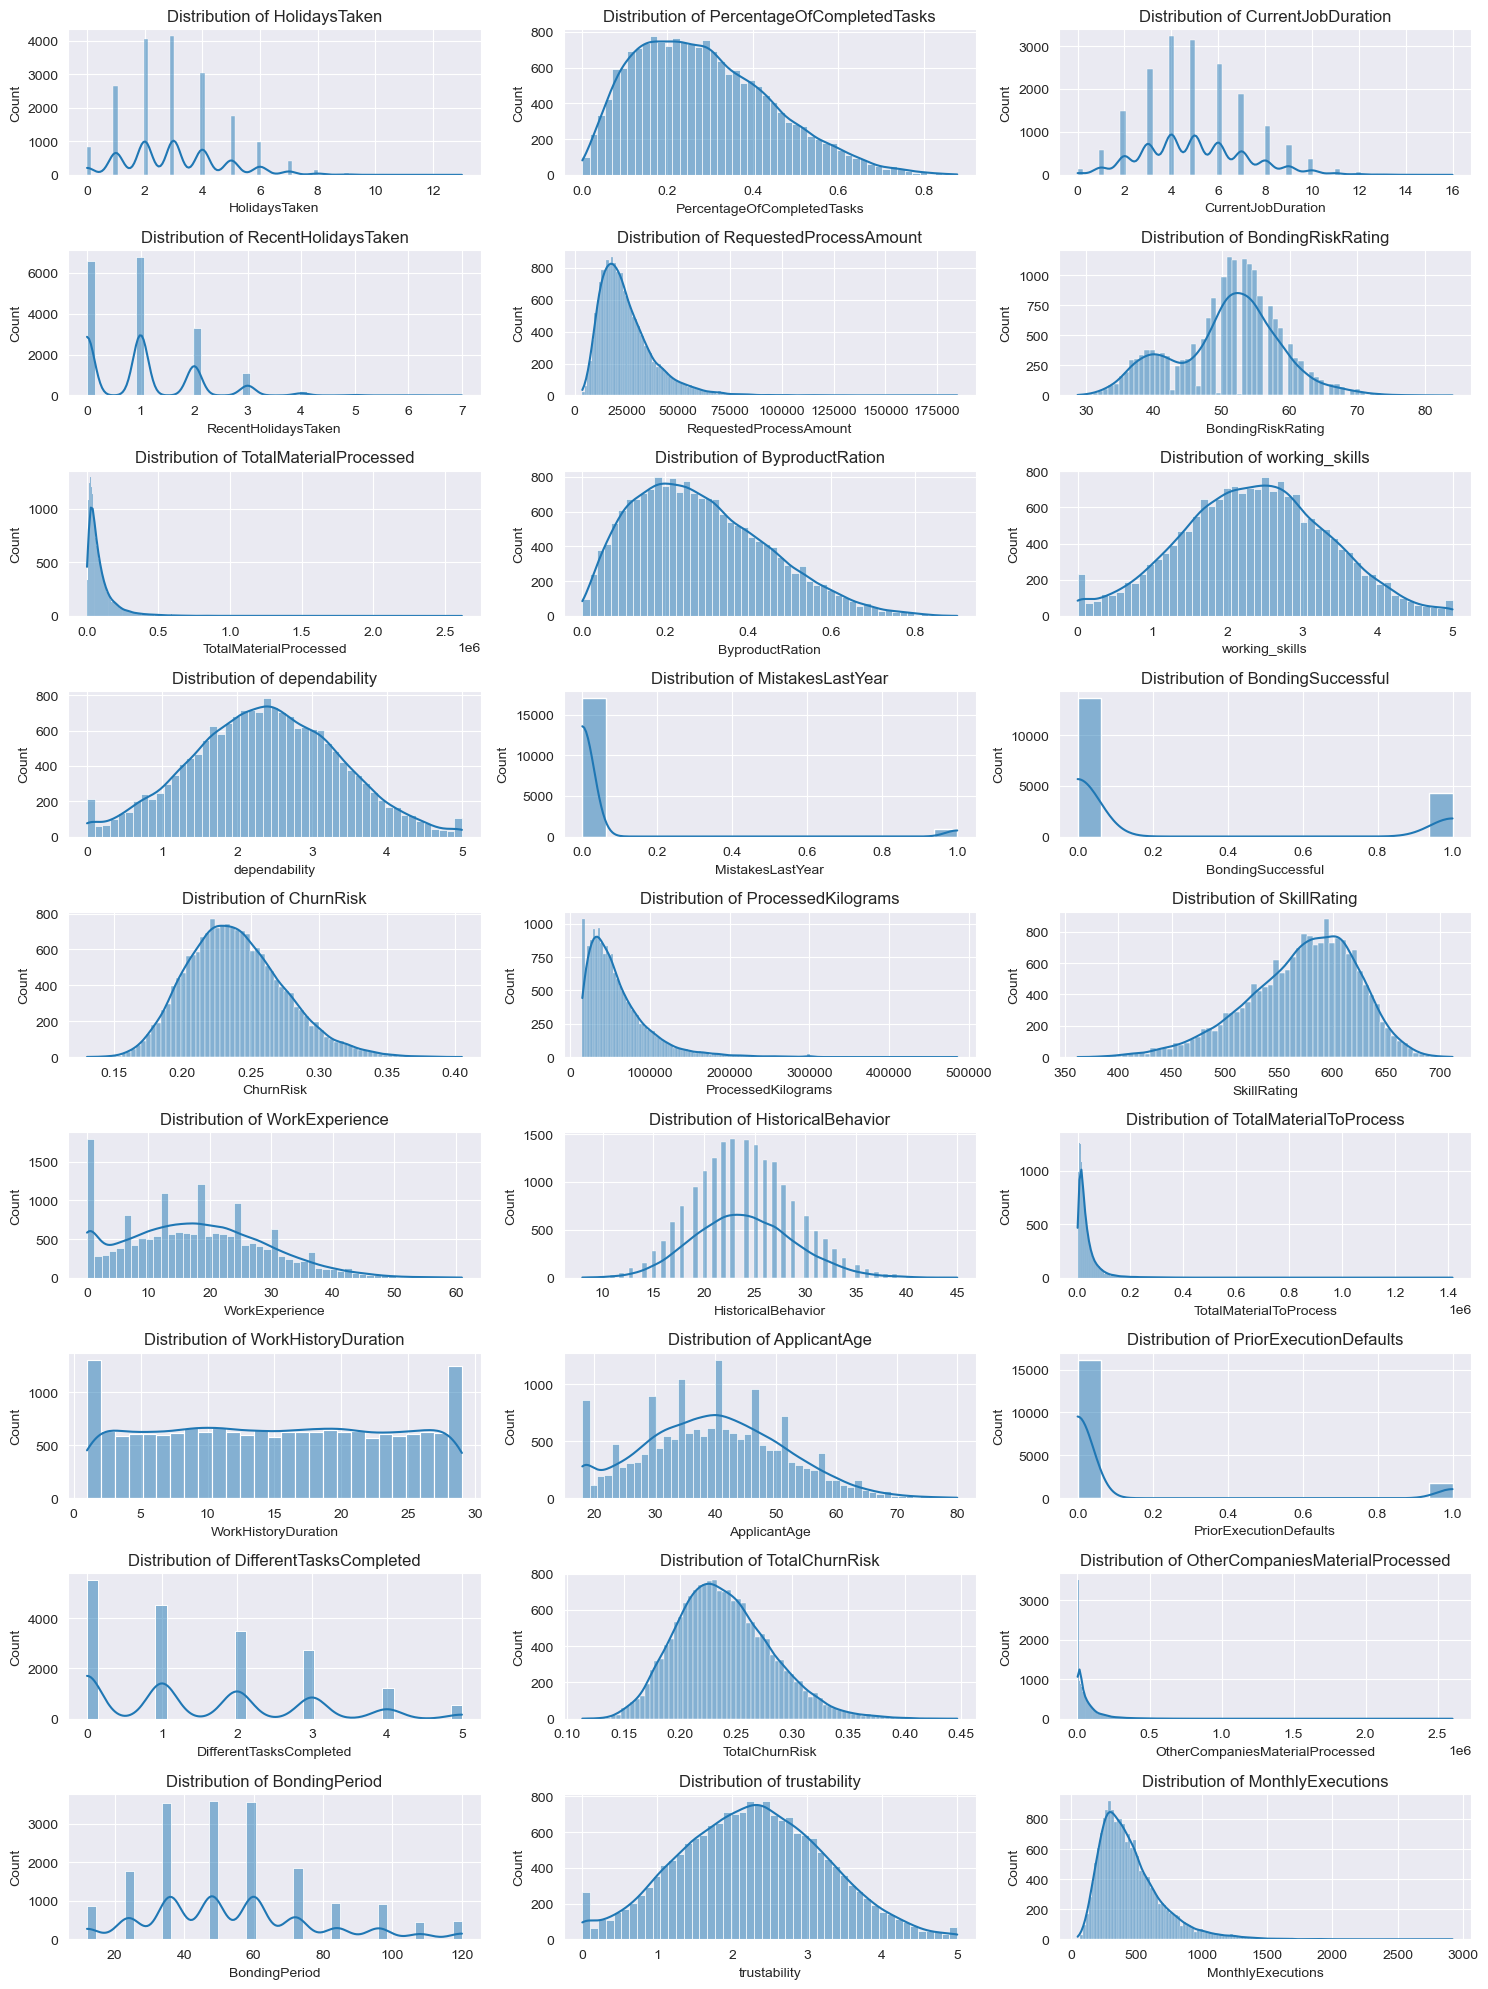

In [256]:
numerical_columns = ds.select_dtypes(include=['float64', 'int64']).columns

# Histograms for numerical features
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(15, 20))
axes = axes.flatten()

for i, col in enumerate(numerical_columns[:27]):
    sns.histplot(ds[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

This series of graphs shows the distribution of all numerical variables within the dataset. Plotting histograms helps understanding the main characteristics of the data; we observe the following:
- `TotalMaterialProcessed`, `OtherCompaniesMaterialProcessed`, `MistakesLastYear` and `PriorExecutionDefaults` show some kind of right-skewness, confirming what we saw a few blocks ago when detecting outliers
- Variables like `trustability` and `SkillRating` show bell-shaped distributions, suggesting normal spreading of data
- `BondingSuccessful` has large imbalance, with significantly more cases of 0 compared to 1
- `HolidaysTaken` and `BondingPeriod` display clear peaks at regular intervals, possibly reflecting organizational or production practices

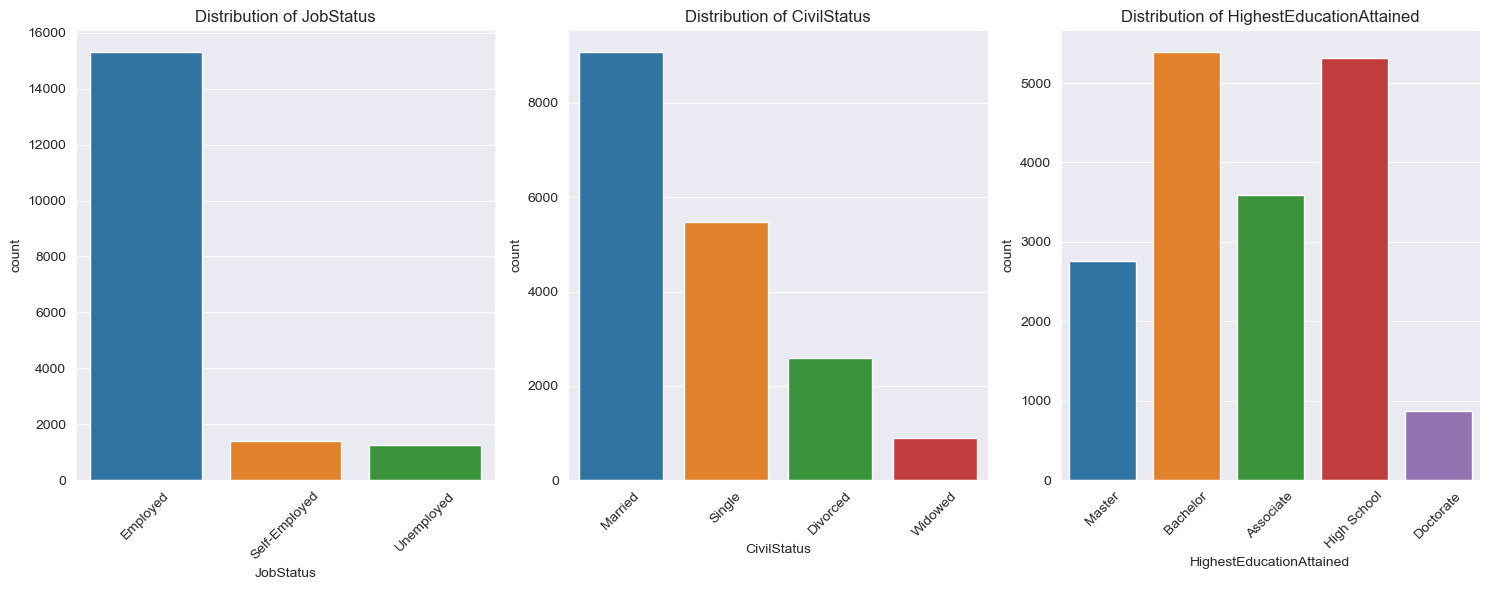

In [257]:
categorical_variables = ['JobStatus', 'CivilStatus', 'HighestEducationAttained']

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
axes = axes.flatten()

for i, col in enumerate(categorical_variables):
    sns.countplot(data=ds, x=col, ax=axes[i], hue=col, dodge=False, legend=False)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

We decide to plot also the distributions for categorical variables to get a complete view of the features.
We gathered the following insights:
- Vast majority of individuals are *employed*, *married* or up to a *bachelor/high school degree*
- Generally speaking, it reflects a population with significant focus on standard employment and education

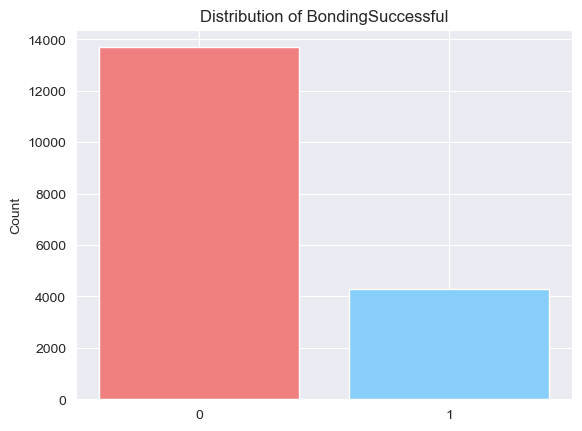

In [258]:
bonding_counts = ds['BondingSuccessful'].value_counts()

# Bar Chart
plt.bar(
    bonding_counts.index,
    bonding_counts.values,
    color=['lightcoral', 'lightskyblue']
)
plt.title('Distribution of BondingSuccessful')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.show()


Looking at this graph we can confirm what we already saw with previous distribiutions' plotting:
- The dataset contains more instances where bonding was unsuccessful (0) compared to successful cases (1)

We can also say that at this stage there are still some null values within this variable which may influence performance later on. <br>
We intend to address both imbalance and presence of null values when processing data.

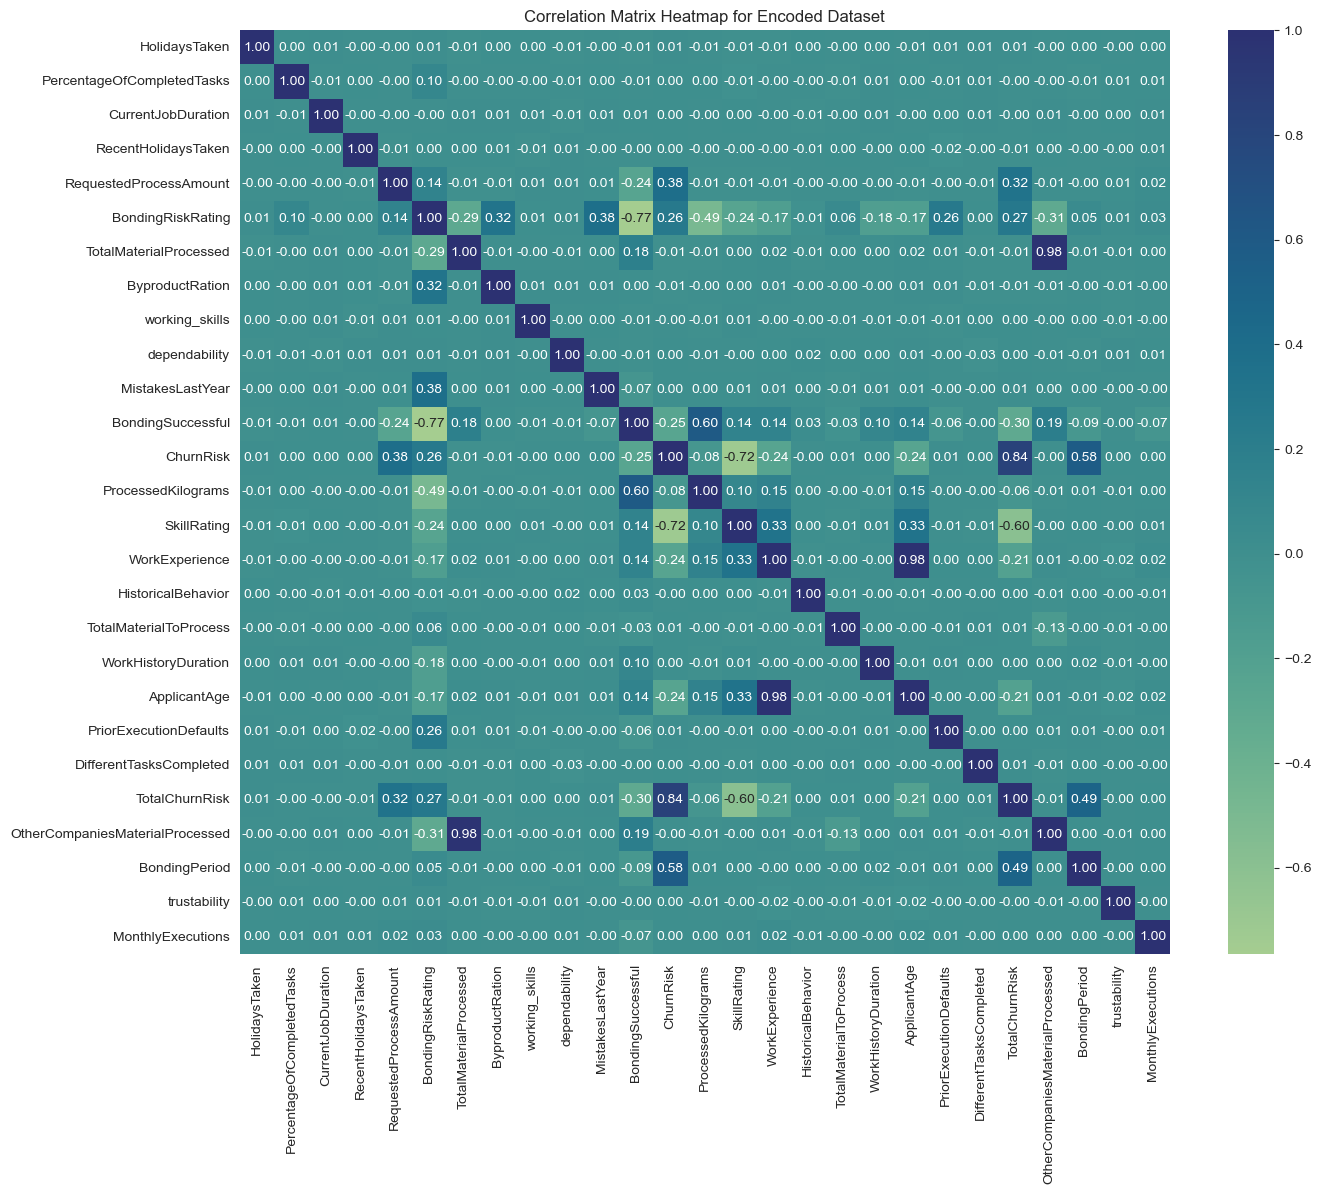

In [259]:
numeric_ds = ds.select_dtypes(include = ['number'])
correlation_matrix = numeric_ds.corr()

# Generate a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='crest', fmt=".2f")
plt.title('Correlation Matrix Heatmap for Encoded Dataset')
plt.show()

The correlational matrix is a tool which provides an overview on how variables are related to each other, with particular attention to their linear relationships. <br>
When analysing our matrix we decide to distinguish two kinds of correlations: the ones which involve our target variable `BondingSuccessful` and the ones that don't.
1. `BondingRiskRating` and `ProcessedKilograms` have respectively the highest negative and positive relation to our target variable &rarr; the first tells us that as the risk increases, the likelihood of a successful bonding decreases, while the second states that processing more material increases the likelihood of successful bonding
2. `OtherCompaniesMaterialProcessed` vs `TotalMaterialProcessed`, `TotalChurnRisk` vs `ChurnRisk`, `ApplicantAge` vs `WorkExperience`, `TotalChurnRisk` vs `SkillRating` show positive/negative correlation above 60% within couples &rarr; these represent redundancies and as such they'll be treated accordingly

In [260]:
columns_to_drop = [
    'OtherCompaniesMaterialProcessed',  
    'SkillRating',                      
    'WorkHistoryDuration',              
    'TotalChurnRisk',
    'ApplicantAge',
    'ProcessingTimestamp'                   
]

# Drop columns in-place
ds.drop(columns=columns_to_drop, inplace=True)

We use the drop function to exclude from the dataset one variable per couple, as anticipated in the previous cell. <br>
We decide to drop also `ProcessingTimestamp` as it results being a very complex feature, let alone useless to our cause. <br>

For what we believe, dropping features is fundamental to maintaining the focus specifically on the data that plead our case, thus avoiding redundancies and irrelevancies.

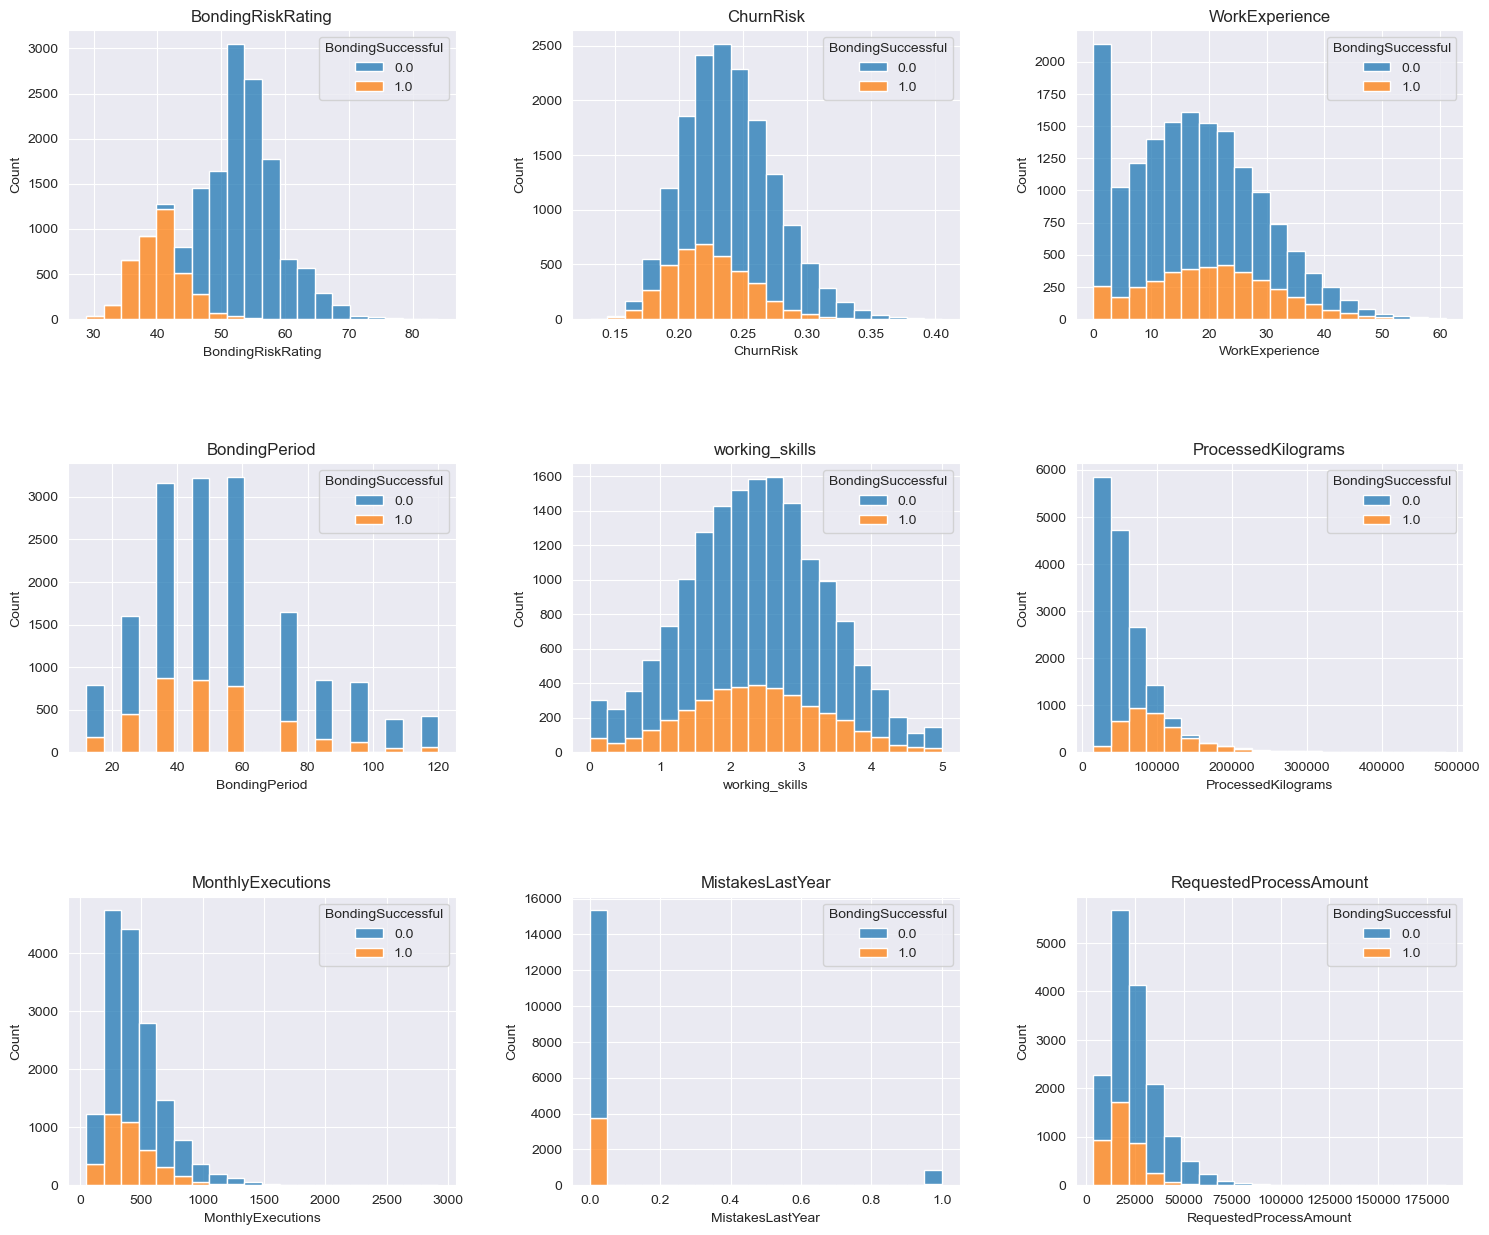

In [261]:
columns = [
    'BondingRiskRating', 'ChurnRisk', 'WorkExperience', 'BondingPeriod',
    'working_skills', 'ProcessedKilograms', 'MonthlyExecutions', 'MistakesLastYear', 'RequestedProcessAmount'
]

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

# Plot histograms for each column
for ax, column in zip(axes, columns):
    sns.histplot(data=ds, x=column, hue='BondingSuccessful', multiple='stack', bins=20, ax=ax)
    ax.set_title(column)

# Hide unused axes
for i in range(len(columns), len(axes)):
    axes[i].set_visible(False)

# Adjust layout
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

A couple of interesting insights when deepening the distribution of key-variables on the target one:
- Bonding is successful when considering individuals with moderate work experience. Very low (< 5 years) and very high (> 30 years) experience shows lower success rates, possibly due to lack of skills or decreasing performance over time
- Successful bonding is associated with smaller processed volumes (< 100.000 kg), while failures increase with larger batches. This indicates that process scalability might be an issue for success

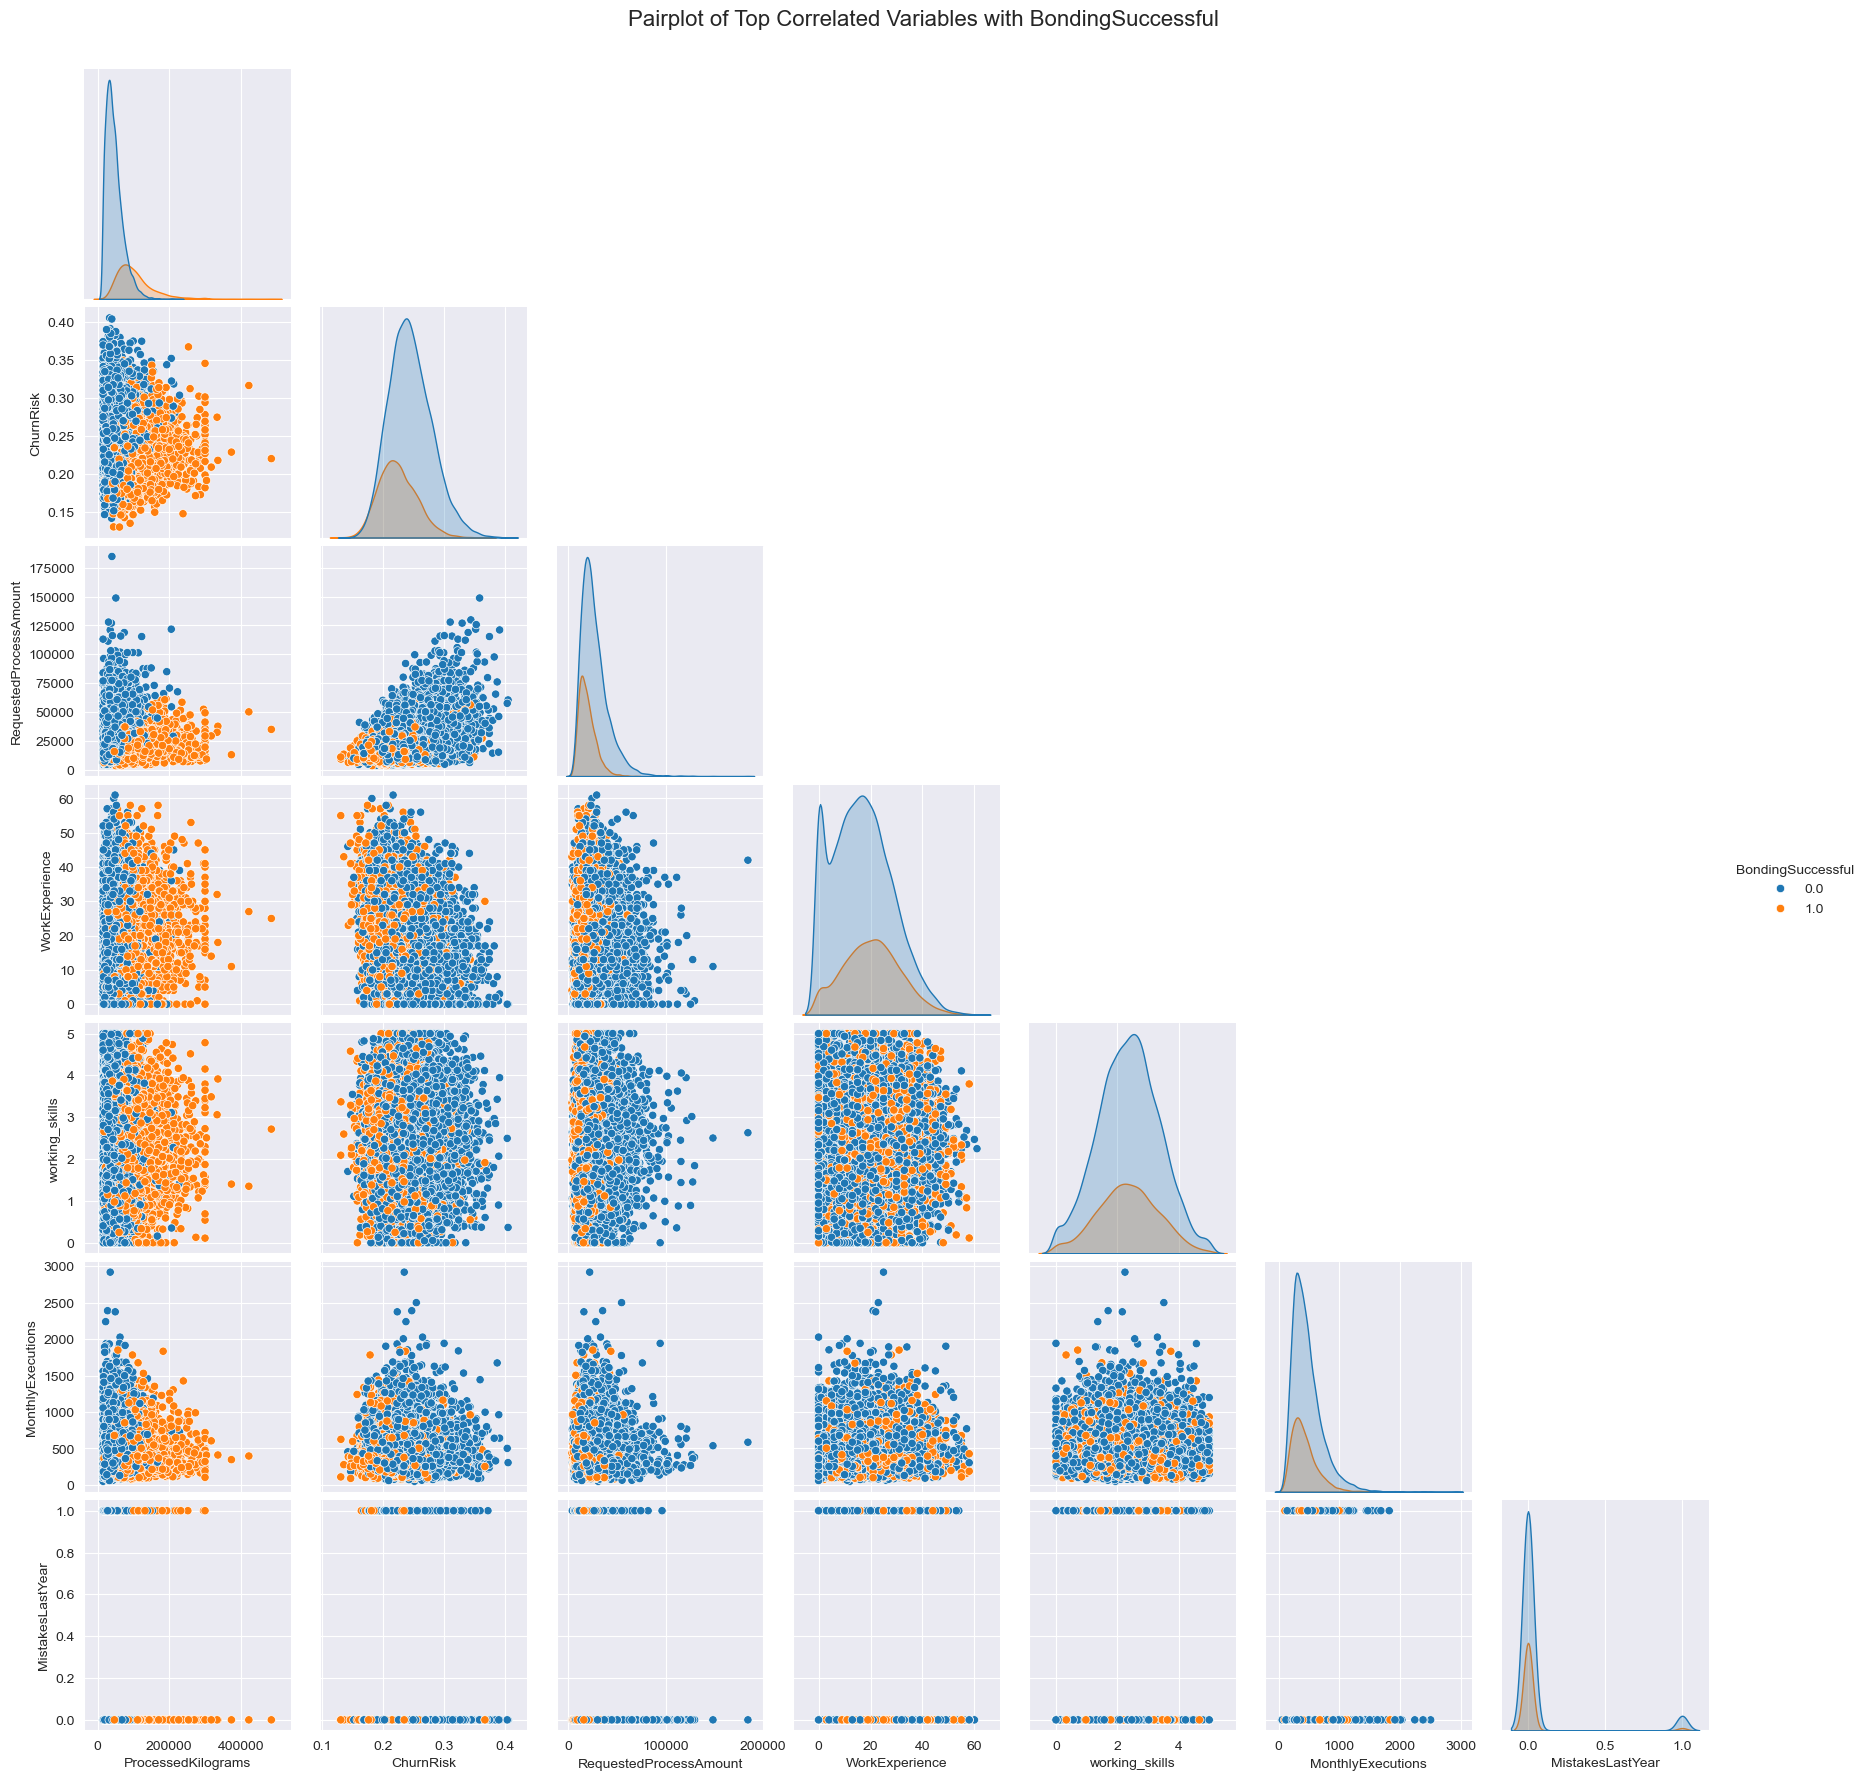

In [262]:
# Define the selected variables for the pairplot
pairplot_variables = [
    'ProcessedKilograms',
    'ChurnRisk',
    'RequestedProcessAmount',
    'WorkExperience',
    'working_skills',
    'BondingSuccessful',
    'MonthlyExecutions',
    'MistakesLastYear'
]

# Generate the pairplot
sns.pairplot(ds[pairplot_variables], hue='BondingSuccessful', diag_kind='kde', corner=True)
plt.suptitle("Pairplot of Top Correlated Variables with BondingSuccessful", y=1.02, fontsize=16)
plt.show()


From the pairplot we can add a couple more information to our understanding of the dataset:
- Several variables, like `ProcessedKilograms` and `RequestedProcessAmount`, show thresholds beyond which success rates drop significantly
- The combination of variables like `ProcessedKilograms`, `MonthlyExecutions`, and `RequestedProcessAmount` suggest that maintaining a balance between high-volume operations and quality control is essential for improving success rates

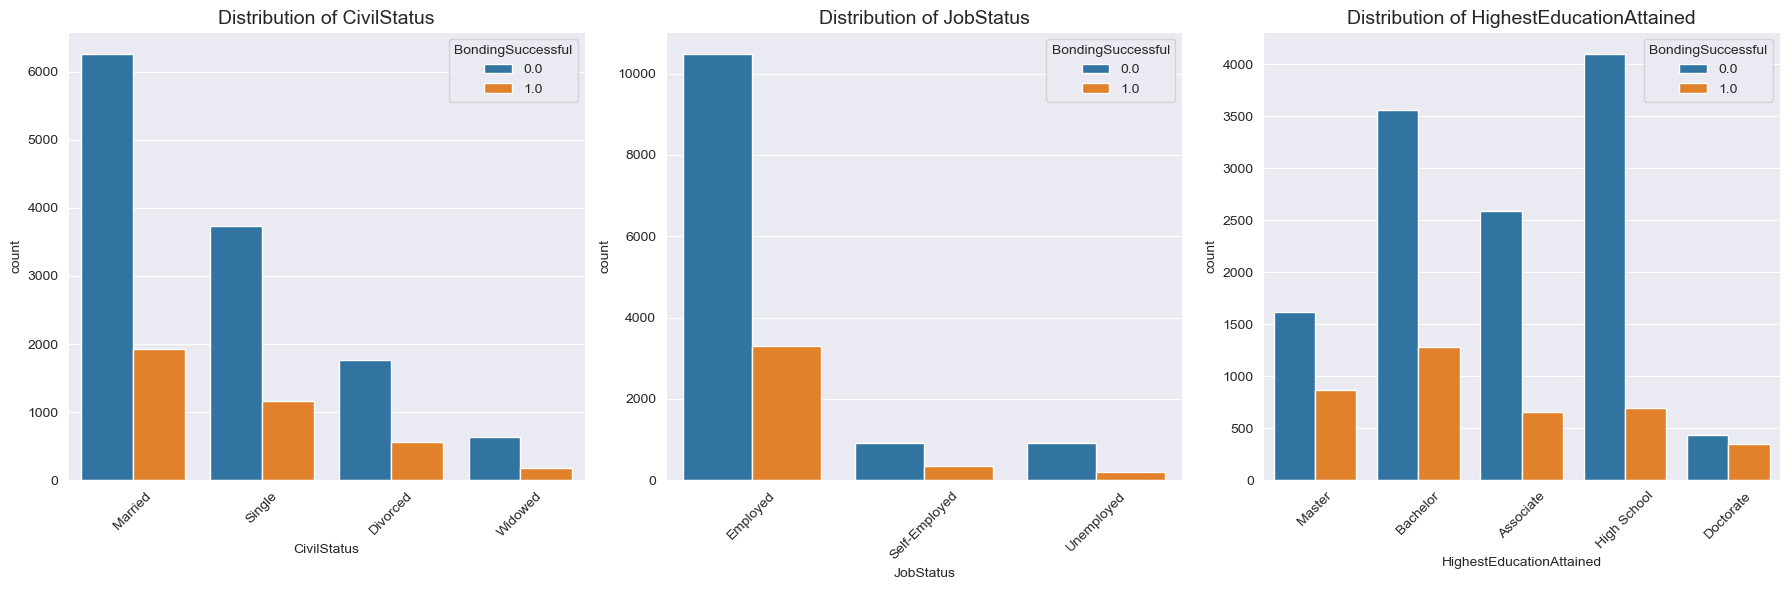

In [263]:
columns = ['CivilStatus', 'JobStatus', 'HighestEducationAttained']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot countplots for each column
for ax, column in zip(axes, columns):
    sns.countplot(data=ds, x=column, hue='BondingSuccessful', ax=ax)
    ax.set_title(f'Distribution of {column}', fontsize=14)
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Adjust layout
plt.tight_layout()
plt.show()

As last tile to complete the broad and immersive understanding of the data, we believe it's noteworthy to give a few insights about categorical variables related to the target variable. <br>
First, although *married* and *employed* are the two dominant characteristics, they don't provide a clear advantage for bonding success. <br>
Finally, categories like self-employed or highly educated individuals might represent specialized roles thus provide little to no information.

# 2. PROCESSING DATA <br>
With this second phase, things start to get exciting. Indeed, prepocessing data is fundamental as raw data often contains inconsistencies, missing values, and noise that can negatively impact results.
Specifically to our dataset, we intend to tackle the following matters:
1. Addressing class imbalance
2. Imputing missing values
3. Encoding categorical variables
4. Scaling
5. Addressing outliers
6. Train & Test split

Getting all of the above done will ensure a smooth ride for the designated ML models to enjoy. <br>
We'll explain more as we glyde through them.

---

## 2.1 Class imbalance

In [264]:
# Define the target variable
target = "BondingSuccessful"
y = ds[target]
X = ds.drop(columns=[target])

# Identify rows where the target variable == 0 and make a copy
unsuccessful = X[y == 0.0].copy()

# Calculate the total number of missing values for each row
unsuccessful['MissingValuesCount'] = unsuccessful.isnull().sum(axis=1)

# Sort the unsuccessful entries by descending
unsuccessful_sorted = unsuccessful.sort_values(by='MissingValuesCount', ascending=False)

# Determine the number of rows to remove
num_to_remove = len(unsuccessful) - len(X[y == 1.0]) * 1.5  # Keep a 3:2 ratio of unsuccessful:successful

num_to_remove = max(0, int(num_to_remove))

# Drop the top rows with highest missing values
unsuccessful_balanced = unsuccessful_sorted.iloc[num_to_remove:]

# Combine the balanced entries
successful = X[y == 1.0].copy()
balanced_X = pd.concat([unsuccessful_balanced, successful])

# Create the balanced target variable
balanced_y = pd.concat([
    pd.Series([0.0] * len(unsuccessful_balanced), index=unsuccessful_balanced.index),
    pd.Series([1.0] * len(successful), index=successful.index)
])

# Drop the fictitious column from the dataset
balanced_X = balanced_X.drop(columns=['MissingValuesCount'])

# Display the class balance in the balanced target variable
balanced_class_balance = balanced_y.value_counts()
print(balanced_class_balance)

0.0    6461
1.0    4307
Name: count, dtype: int64


As we pointed out during the EDA, our target variable `BondingSuccessful` is highly imbalanced between the cases of failure and success. <br>
To address this problem we're required to balance it by reducing the size of the majority class (unsuccessful cases, 0.0): to do so we create a fictitious variable  `MissingValuesCount` that counts missing entries for every row where the bonding process has failed; we then decide to keep a 3:2 ratio of unsuccessful cases to successful ones and to eliminate redundant entries according to the established proportion.

## 2.2 Scaling, imputing and encoding

In [265]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separate numerical and categorical columns in the balanced dataset
numeric_columns = balanced_X.select_dtypes(include=["int64", "float64"]).columns
categorical_columns = balanced_X.select_dtypes(include=["object", "category"]).columns

# Define transformers for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Median imputation
    ("scaler", StandardScaler())  # Standardize features
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Mode imputation
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # One-hot encode categorical features
])

# Combine transformations into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_columns),
        ("cat", categorical_transformer, categorical_columns)
    ]
)

# Fit and transform the balanced dataset
X_balanced_processed = preprocessor.fit_transform(balanced_X)

# Verify the shape and ensure no missing values
missing_values_final = np.isnan(X_balanced_processed).sum()
print(f"Missing values in the processed dataset: {missing_values_final}")

# Verify the shape of the transformed dataset
print(f"Shape of processed dataset: {X_balanced_processed.shape}")

Missing values in the processed dataset: 0
Shape of processed dataset: (10768, 33)


Here we use the power of the Pipeline tool to tackle the second, third and fourth tasks simoultaneously. A Pipeline is an incredibly efficient tool that automates the sequence of preprocessing steps applied to data. It ensures that transformations are consistently and correctly applied to our dataset.<br>
Let us explain how we take the most out of it:
- We start by filling missing values, and to do so we choose two different imputers:
    1. **Median**, which fills missing values for numerical variables using the median value within that variable
    2. **Mode**, which fills missing values for categorical variables using the value that appears the most within that variable
- We then scale all values using the *StandardScaler*. We opt for a standard scaling method as it uses mean and standard deviation to scale, perfectly fitting our needs
- Finally, we encode and transforme categorical variables using *OneHotEncoder*. All it does is creating a binary column for each category in a categorical feature. Then, each row in the dataset gets a 1 in the column corresponding to its category and 0 in all other columns

We also notice that all missing values have been imputed correctly.

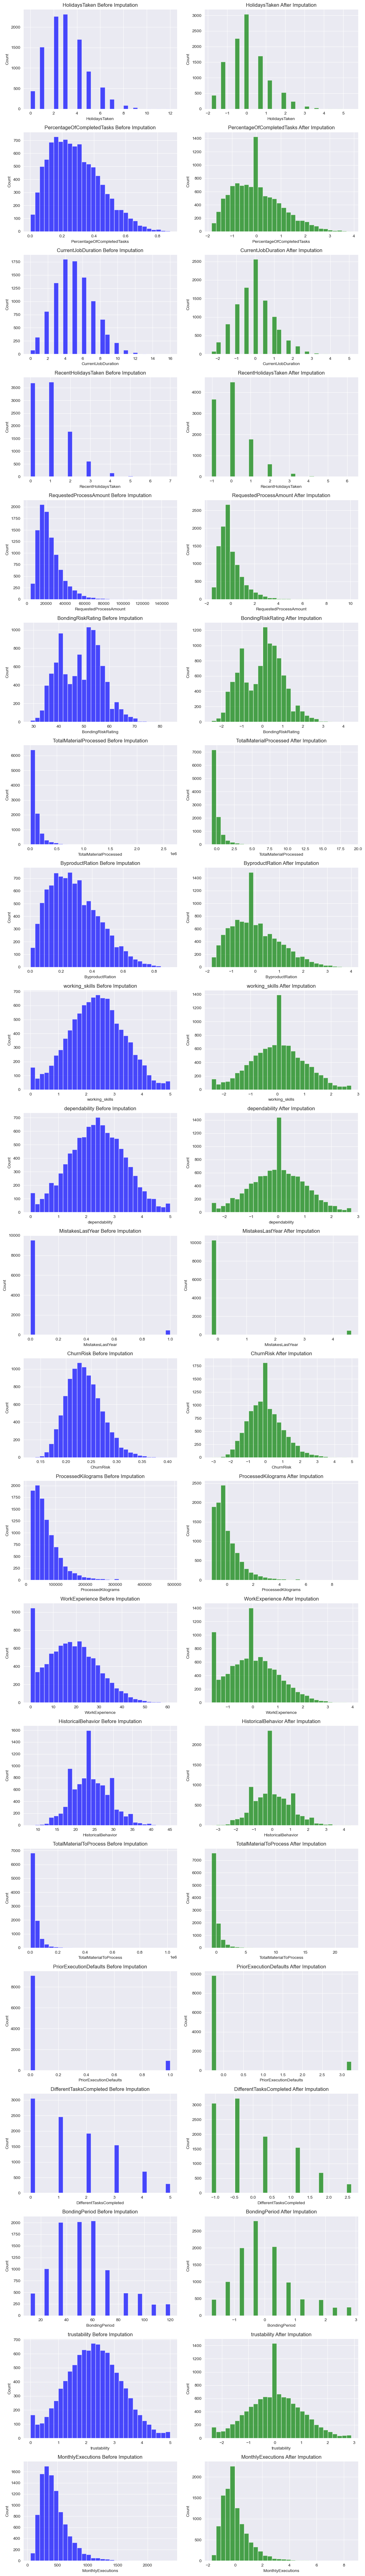

In [266]:
fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(12, len(numeric_columns) * 4))
for i, column in enumerate(numeric_columns):
    # Before imputation
    axes[i, 0].hist(balanced_X[column].dropna(), bins=30, color='blue', alpha=0.7)
    axes[i, 0].set_title(f"{column} Before Imputation")
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel("Count")

    # After imputation
    imputed_data = X_balanced_processed[:, i]
    axes[i, 1].hist(imputed_data, bins=30, color='green', alpha=0.7)
    axes[i, 1].set_title(f"{column} After Imputation")
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

With these graphs we intend to underline the variables that changed the most after the imputation of their missing values:
- `Trustability`'s distribution shifts towards the center, reducing the impact of missing values
- `PercentageOfCompletedTasks` reduces noticeably its variability
- `ChurnRisk` smooths allround

In [267]:
# Retrieve encoded feature names
encoded_feature_names = preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(categorical_columns)

# Display only the new columns added
print("New columns added after encoding categorical variables:")
for feature in encoded_feature_names:
    print(feature)

New columns added after encoding categorical variables:
JobStatus_Employed
JobStatus_Self-Employed
JobStatus_Unemployed
CivilStatus_Divorced
CivilStatus_Married
CivilStatus_Single
CivilStatus_Widowed
HighestEducationAttained_Associate
HighestEducationAttained_Bachelor
HighestEducationAttained_Doctorate
HighestEducationAttained_High School
HighestEducationAttained_Master


These are the new columns that have been created after encoding and transforming categorical variables.

## 2.2 Splitting cleaned dataset into train and test sets

A common practice is to split the dataset into two sets: **training** and **test** sets. This procedure allows us to evaluate the model's performance on unseen data.

In [268]:
from sklearn.model_selection import train_test_split

# Split the preprocessed dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced_processed, balanced_y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

Training set size: (8614, 33), Testing set size: (2154, 33)


We decide to take an ordinary split into 80% for the training set and 20% for the test set. <br>
The training set is used to fit the model, allowing it to familiarize with patterns and relationships from the data. The test set simulates the unseen data, which is helpful to know how well the trained model generalizes on new instances. It ensures that the model doesn't just memorize the training data and makes sure it will perform well on new, untrained examples. <br>
By keeping the test set separate, we prevent any influence of testing data on the training process, which could lead to overly optimistic performance estimates.

---

Having faith that we still have your attention, you might have noticed that we haven't addressed outliers yet—and that's intentional. At the start of this project, we promised not to remove outliers, and we’ve stuck to that plan. <br>
After considering and rejecting the idea of removing outliers solely from the target variable, we concluded that eliminating them from the rest of the dataset wasn’t necessary either. This decision aligns with our earlier reduction of the dataset by dropping 6 of the initial 31 columns. Moreover, standard scaling and balancing, which we’ve already applied, help mitigate the effects of outliers. <br>
Lastly, the tree-based models we’re training are inherently robust to outliers, further supporting our choice.

# 3. TESTING BASE MODELS <br>
Hold on tight! We're finally getting to what we plead to be the heart of the project :) <br>
In this section we'll deploy and test three different machine learning models. Let us remember you that our problem is of **classification** and our target variable is `BondingSuccessful`. Acknowledging the fact that this is a *binary variable*, we take the chance and start with a simple model: **Logistic Regression**. We then proceed with two more advanced models such as **Random Forest** and **Gradient Boosting**.

## 3.1 Logistic Regression <br>
Logistic Regression is a simple and interpretable linear model used for binary classification tasks.
It predicts the probability of an outcome belonging to a particular class by fitting a linear relationship between the features and the log-odds of the target class.

In [269]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(random_state=42)

model.fit(X_train, y_train)
y_pred_lr = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_lr)

print("\n=== Logistic Regression Results ===")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))


=== Logistic Regression Results ===
Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1315
         1.0       0.98      0.95      0.97       839

    accuracy                           0.97      2154
   macro avg       0.98      0.97      0.97      2154
weighted avg       0.97      0.97      0.97      2154



Straight away we see that the base model is performing outstandingly well, suggesting that the relationship between the features and the target variable is well-captured. <br>
The overall accuracy of 97% indicates that the model predicts the target variable correctly almost every time. The support values (1315 for class 0 and 839 for class 1) show mild class imbalance as expected and programmed. The model still achieves near-perfect scores for both classes, indicating it handles the slight imbalance well. <br>
We observe more from the learning curve.

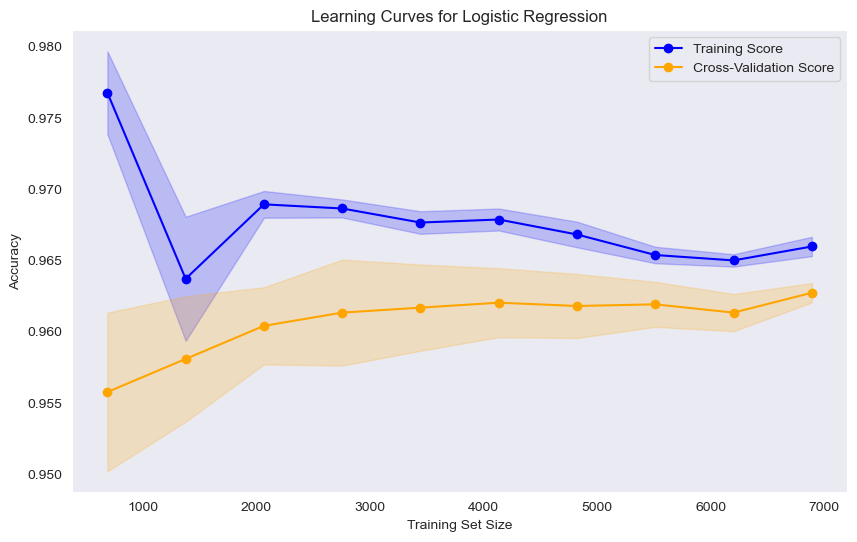

In [270]:
from sklearn.model_selection import learning_curve

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training Score", color="blue")
plt.plot(train_sizes, test_mean, 'o-', label="Cross-Validation Score", color="orange")

# Fill areas for standard deviation
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="orange")

# Formatting the plot
plt.title("Learning Curves for Logistic Regression")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()

From the plotting of the learning curve we observe:
- Training accuracy is consistently high, starting at nearly 0.98 and gradually stabilizing around 0.965 as the training set size increases
- The cross-validation score starts lower but steadily improves as the training set size increases, converging close to the training accuracy. Hence the model generalizes better as data size increases, reducing overfitting
- Beyond a certain dataset size (~4000 samples), the validation score plateaus, suggesting the model's performance has stabilized and that adding more data would yield diminishing returns.

Since the two curves almost converge, there could still be some room for improvement with hyperparameter tuning.

## 3.2 Random Forest <br>
Random Forest is an ensemble model that combines multiple decision trees, where each tree is trained on a random subset of the data and features.
The final prediction is made by aggregating the outputs of individual trees (e.g., majority voting for classification). <br>
We take a chance and oversample the minority class using SMOTE (Synthetic Minority Oversampling Technique): our goal here is not to balance again the target variable, rather to increase the dataset's size to counteract overfitting.

In [271]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
n_estimators=100,
random_state=42,
)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_model.fit(X_train_smote, y_train_smote)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("\n=== Random Forest Results ===")
print(f"Accuracy: {accuracy_rf:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))


=== Random Forest Results ===
Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1315
         1.0       0.97      0.96      0.96       839

    accuracy                           0.97      2154
   macro avg       0.97      0.97      0.97      2154
weighted avg       0.97      0.97      0.97      2154



Also here the base model is performing incredibly well. In both classes *precision* and *recall* exhibit high scores, showing the model correctly detecting false-positives and true-negatives. <br>
Random Forest handles greatly the slight imbalance, however, the lower recall for Class 1 suggests the model might slightly favor the majority class. <br>
SMOTE helps a little in increasing the *accuracy* score compared to previous trials without it. <br>
With respect to the previous model it achieves a similar overall accuracy, while the linear model still outperforms it in *recall* for Class 1. 

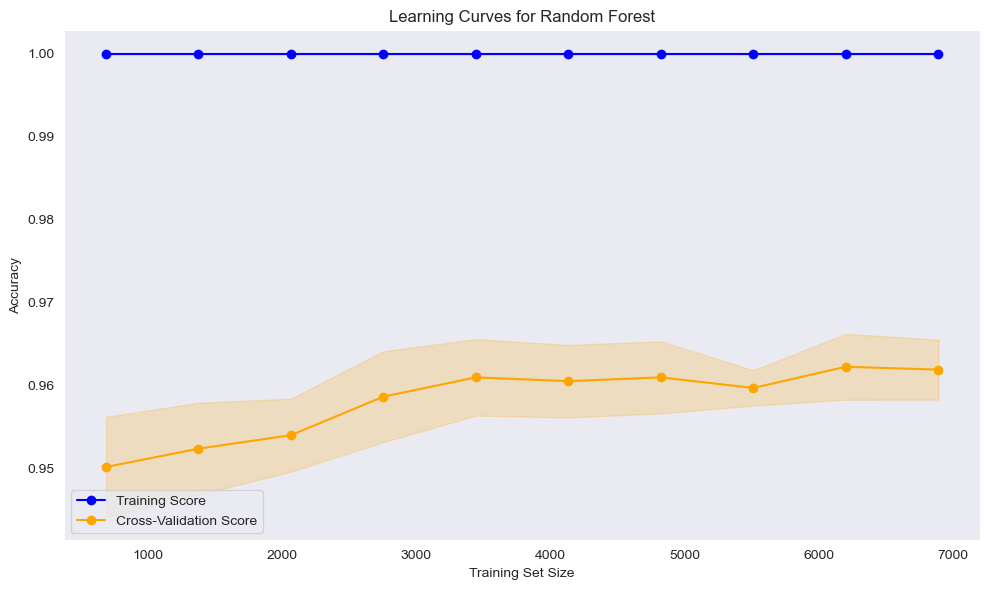

In [272]:
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(
    rf_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_mean_rf = np.mean(train_scores_rf, axis=1)
train_std_rf = np.std(train_scores_rf, axis=1)
test_mean_rf = np.mean(test_scores_rf, axis=1)
test_std_rf = np.std(test_scores_rf, axis=1)

# Plot the learning curves for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_rf, train_mean_rf, 'o-', label="Training Score", color="blue")
plt.plot(train_sizes_rf, test_mean_rf, 'o-', label="Cross-Validation Score", color="orange")

# Fill areas for standard deviation
plt.fill_between(train_sizes_rf, train_mean_rf - train_std_rf, train_mean_rf + train_std_rf, alpha=0.2, color="blue")
plt.fill_between(train_sizes_rf, test_mean_rf - test_std_rf, test_mean_rf + test_std_rf, alpha=0.2, color="orange")

# Formatting the plot
plt.title("Learning Curves for Random Forest")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()

Plotting the learning curve for Random Forest we observe the following:
- The training score is fixed at 100% accuracy, which is a distinctive sign of this model as it tends to overfit due to the ensemble nature of decision trees
- The cross-validation score starts lower, around 0.95, and progressively increases as the training set size grows, stabilizing near 0.96; this reflects a good generalization
- Even with the oversampling, hence a bigger dataset, the model still overfits; at least we tried...

We conclude once more that the choice of keeping outliers is a wise one, as reducing the data further would've definetely influenced the scores for the worse.

## 3.3 Gradient Boosting <br>
Gradient Boosting is another ensemble method that builds trees sequentially, where each new tree corrects the errors made by the previous ones.
It optimizes for a loss function (e.g., log loss for binary classification) and focuses on difficult-to-predict examples.

In [273]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

print("\n=== Gradient Boosting Results ===")
print(f"Accuracy: {accuracy_gb:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_gb))


=== Gradient Boosting Results ===
Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1315
         1.0       0.97      0.97      0.97       839

    accuracy                           0.98      2154
   macro avg       0.98      0.98      0.98      2154
weighted avg       0.98      0.98      0.98      2154



Gradient Boosting performs well due to its iterative nature, which corrects previous errors and enhances predictions. Indeed, as of now it's the model with the highest score. <br>
Compared to its predecessor, Gradient Boosting slightly improves the *recall* for both classes, reducing false negatives further. This is typical as it handles overfitting better due to its iterative nature and learning rate parameter. Each tree focuses on "harder-to-predict" samples by assigning higher weights to those misclassified, improving *recall* and overall balance.

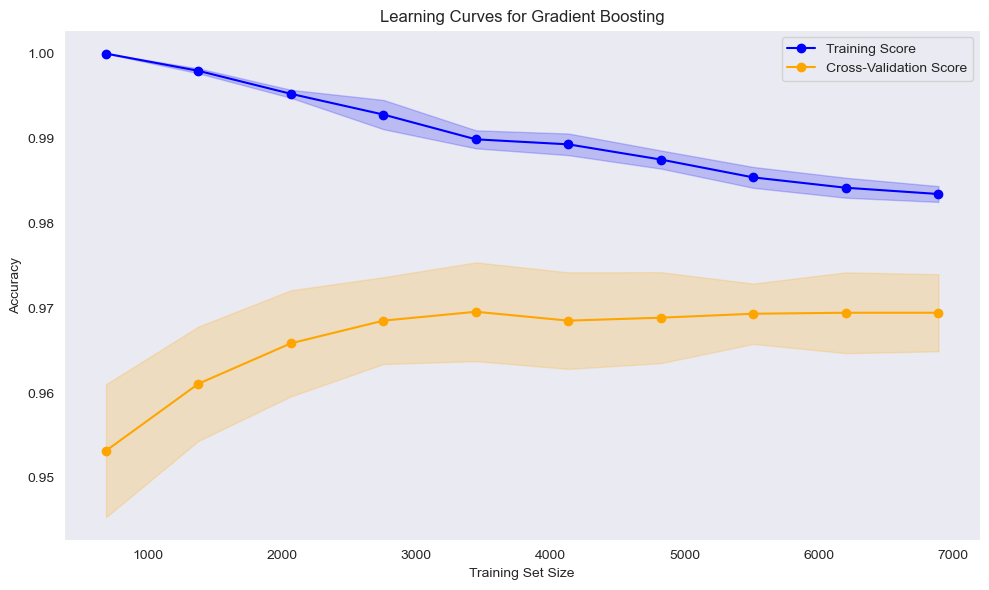

In [274]:
train_sizes_gb, train_scores_gb, test_scores_gb = learning_curve(
    gb_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_mean_gb = np.mean(train_scores_gb, axis=1)
train_std_gb = np.std(train_scores_gb, axis=1)
test_mean_gb = np.mean(test_scores_gb, axis=1)
test_std_gb = np.std(test_scores_gb, axis=1)

# Plot the learning curves for Gradient Boosting
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_gb, train_mean_gb, 'o-', label="Training Score", color="blue")
plt.plot(train_sizes_gb, test_mean_gb, 'o-', label="Cross-Validation Score", color="orange")

# Fill areas for standard deviation
plt.fill_between(train_sizes_gb, train_mean_gb - train_std_gb, train_mean_gb + train_std_gb, alpha=0.2, color="blue")
plt.fill_between(train_sizes_gb, test_mean_gb - test_std_gb, test_mean_gb + test_std_gb, alpha=0.2, color="orange")

# Formatting the plot
plt.title("Learning Curves for Gradient Boosting")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()

The learning curve reveals interesting information:
- Training accuracy drops quite gradually indicating that the model learns and regularizes well
- The cross validation curve converges steadily, showing it definitely generalizes better compared to the previous model
- The perfect training accuracy for small training sizes suggests the model overfits in these cases. This behavior is typical for Gradient Boosting due to its iterative nature and emphasis on reducing errors

# 4. HYPERPARAMETER TUNING

After testing models with base parameters and still achieving quite some impressive scores, we try to tune hyperparameters to see if we can reach even higher scores. To do so we'll use two different libraries: *GridSearch* and *RandomizedSearch*.

## 4.1 GridSearch on Logistic Regression

*GridSearch* systematically tests a predefined set of hyperparameter combinations to find the optimal configuration that maximizes model performance. These parameters include:
- **C** &rarr; it's the inverse of regularization strength, balancing between fitting the training data and preventing overfitting
- **Penalty** &rarr; it specifies the type of regularization

and others.

In [275]:
import time
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'penalty': ['elasticnet'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'solver': ['saga'],
        'l1_ratio': [0.1, 0.5, 0.9],
        'max_iter': [1000],
    }
]

start_time_lr_tuned = time.time()

# Perform grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

end_time_lr_tuned = time.time()
running_time_lr_tuned = end_time_lr_tuned - start_time_lr_tuned

# Best hyperparameters and score
print("=== Grid Search Results ===")
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation F1-Score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_lr_tuned = best_model.predict(X_test)

# Print evaluation metrics
print("\n=== Test Set Results ===")
print("Test Set Accuracy:", accuracy_score(y_test, y_pred_lr_tuned))
print("Classification Report:")
print(classification_report(y_test, y_pred_lr_tuned))

Fitting 5 folds for each of 21 candidates, totalling 105 fits
=== Grid Search Results ===
Best Parameters: {'C': 0.1, 'l1_ratio': 0.1, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}
Best Cross-Validation F1-Score: 0.9533416052345001

=== Test Set Results ===
Test Set Accuracy: 0.9744661095636026
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1315
         1.0       0.98      0.95      0.97       839

    accuracy                           0.97      2154
   macro avg       0.98      0.97      0.97      2154
weighted avg       0.97      0.97      0.97      2154



We see that the score for *accuracy* has a very marginal improvement. This is due to base Logistic Regression being already well-regularized with reasonable default hyperparameters; it is also the case of this linear model struggling at grasping complex, non-linear relationships in the data. <br>
The parameter `ElasticNet` creates sparsity, effectively reducing the model's complexity without the need to compromise performance.

## 4.2 RandomizedSearch on Random Forest
*RandomizedSearch* samples randomly combinations from the specified parameter distribution (e.g., `param_dist`) instead of exhaustively searching through all possible combinations. We choose this method over *GridSearch* simply to reduce computational time.

In [276]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [10, 20, 30, None],  
    'min_samples_split': randint(2, 10), 
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

start_time_rf_tuned = time.time()

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit with training data
random_search.fit(X_train, y_train)

end_time_rf_tuned = time.time()
running_time_rf_tuned = end_time_rf_tuned - start_time_rf_tuned

# Best hyperparameters and score
print("=== Randomized Search Results ===")
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Evaluate on the test set
best_rf_model = random_search.best_estimator_
y_pred_rf_tuned = best_rf_model.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_pred_rf_tuned))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_tuned))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=121; total time=   1.4s
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=121; total time=   1.4s
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=121; total time=   1.4s
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=121; total time=   1.5s
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=121; total time=   1.4s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=264; total time=   2.8s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_s

In this case the tuned model bumps up a little in *accuracy* score compared to the base one. The use of `class_weight='balanced_subsample'` adds a layer of protection against class imbalance. <br>
The combination of `max_depth=30`, `min_samples_split=3` and `max_features='log2'` adds regularization and prevents overfitting by limiting depth and splitting conditions.

## 4.3 RandomizedSearch on Gradient Boosting

We choose *RandomizedSearch* also to tune this last model for the very same purpose of before: computational time. With complex models like Gradient Boosting and *GridSearch* testing combinations to an exponential growth in search space, it would take a while before receiving a concrete output.

In [277]:
from scipy.stats import uniform

# Define the refined parameter grid
param_dist = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': [3, 5, 7],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'subsample': uniform(0.8, 0.2) 
}

start_time_gb_tuned = time.time()

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

end_time_gb_tuned = time.time()
running_time_gb_tuned = end_time_gb_tuned - start_time_gb_tuned

# Output the best hyperparameters and score
print("=== Randomized Search Results ===")
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Evaluate on the test set
best_gb_model = random_search.best_estimator_
y_pred_gb_tuned = best_gb_model.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_pred_gb_tuned))
print("Classification Report:")
print(classification_report(y_test, y_pred_gb_tuned))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END learning_rate=0.047454011884736254, max_depth=3, min_samples_leaf=3, min_samples_split=4, n_estimators=171, subsample=0.9197316968394074; total time=   4.0s
[CV] END learning_rate=0.047454011884736254, max_depth=3, min_samples_leaf=3, min_samples_split=4, n_estimators=171, subsample=0.9197316968394074; total time=   4.1s
[CV] END learning_rate=0.047454011884736254, max_depth=3, min_samples_leaf=3, min_samples_split=4, n_estimators=171, subsample=0.9197316968394074; total time=   4.2s
[CV] END learning_rate=0.02428668179219408, max_depth=7, min_samples_leaf=2, min_samples_split=6, n_estimators=101, subsample=0.944399754453365; total time=   5.6s
[CV] END learning_rate=0.02428668179219408, max_depth=7, min_samples_leaf=2, min_samples_split=6, n_estimators=101, subsample=0.944399754453365; total time=   5.7s
[CV] END learning_rate=0.10385527090157502, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=12

Finally, here the improvement in *accuracy* is very little to none. <br>
Introducing a lower learning rate and subsampling, along with regularization via `min_samples_split` and `min_samples_leaf`, reduced overfitting while mantaining flexibility. The optimized model is better regularized, leading to improved generalization and slightly better performance.

# 5. TESTING OUR NEURONS

After testing more "common" models, we want to push our boundaries further and build an **Artifical Neural Network**. <br>
An ANN can be utilized to predict the success of bonding processes by learning complex, non-linear relationships between features. It consists of:
- **Input Layer**: it absorbs the features of the dataset
- **Hidden Layers**: they contain neurons that process and combine feature information through weighted connections and activation functions
- **Output Layer**: it provides the prediction for the target variable BondingSuccessful (0 or 1)

Note that with our target variable being **binary**, we understand we don't really need the computational power of this complex model; still, we want to try ourselves for the sake of the experiment!

In [285]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

# Define the ANN model
model_ann = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_ann.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=5,           
    restore_best_weights=True
)

start_time_ann = time.time()

history = model_ann.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,            
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

end_time_ann = time.time()
running_time_ann = end_time_ann - start_time_ann

Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 910us/step - accuracy: 0.6681 - loss: 1.3512 - val_accuracy: 0.9327 - val_loss: 0.7773
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.9122 - loss: 0.7193 - val_accuracy: 0.9547 - val_loss: 0.4541
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - accuracy: 0.9478 - loss: 0.4592 - val_accuracy: 0.9623 - val_loss: 0.3270
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.9602 - loss: 0.3327 - val_accuracy: 0.9623 - val_loss: 0.2605
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.9604 - loss: 0.2660 - val_accuracy: 0.9634 - val_loss: 0.2196
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.9583 - loss: 0.2323 - val_accuracy: 0.9640 - val_loss: 0.1937
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.9654 - loss: 0.1949 - val_accuracy: 0.9600 - val_loss: 0.1777
Epoch 8/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.9608 - loss: 0.1885 - 

We use two different activation functions here: **ReLu** and **Sigmoid**. The first one is common for hidden layers due to its semplicity, furthermore it introduces sparsity improving model efficiency; the second activation function is used for the output layer to reduce the predictions to the range [0, 1], which is exactly what we need given our binary target variable. <br>
`binary_crossentropy` is the chosen loss function: it measures the difference between predicted probabilities and actual labels. <br>
Lastly, because of the relatively big size of the dataset, we introduce EarlyStopping: this is used to monitor validation loss and eventually stop training early if the loss does not improve for 5 consecutive epochs.

In [286]:
model_ann.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,869 (50.27 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,580 (33.52 KB)

Using the `.summary()` function we see the final architecture of our ANN. We can distinguish dense layers, where the last one only hosts the output for the model, from dropout layers: these particular layers are used after each dense one to prevent overfitting; indeed, during training the dropout rate at 0.3 sets 30% of the neurons to zero to promote well-spread feature learning.

In [291]:
# Evaluate on the test set
test_loss, test_accuracy = model_ann.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

# Generate predictions
y_pred_prob = model_ann.predict(X_test)
y_pred_art= (y_pred_prob > 0.45).astype(int)

# Print classification report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_art))

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.9773 - loss: 0.0986

Test Accuracy: 0.98
Test Loss: 0.11
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1315
         1.0       0.98      0.96      0.97       839

    accuracy                           0.97      2154
   macro avg       0.97      0.97      0.97      2154
weighted avg       0.97      0.97      0.97      2154



The test set *accuracy* stabilizes at 97% which is close to be the best score. Consequently, the test *loss* is 0.11, aligning with the high accuracy and suggesting that the predictions are generally close to the real labels. <br>
The ANN's strong performance, combined with its ability to model non-linear relationships, makes it a suitable choice for the binary classification problem even on our relatively big dataset.

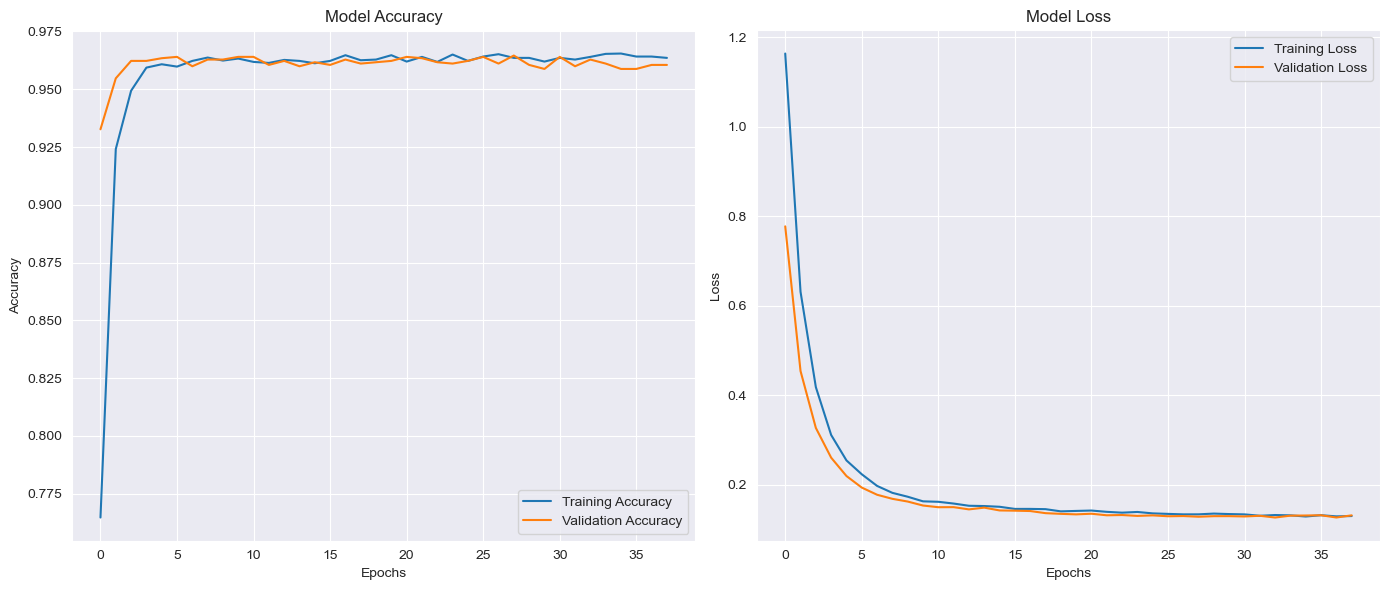

In [288]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot accuracy on the first subplot
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot loss on the second subplot
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


Key observations from these graph:
- Training and validation curves align closely for accuracy and loss, indicating (surprisingly) that the model is not overfitting on training data. The early stopping likely contributed to this optimal convergence
- Fluctuations are quite noticeable for the validation curve; these are likely because of the size of the set or a relatively low learning rate.

# 6. RESULTS

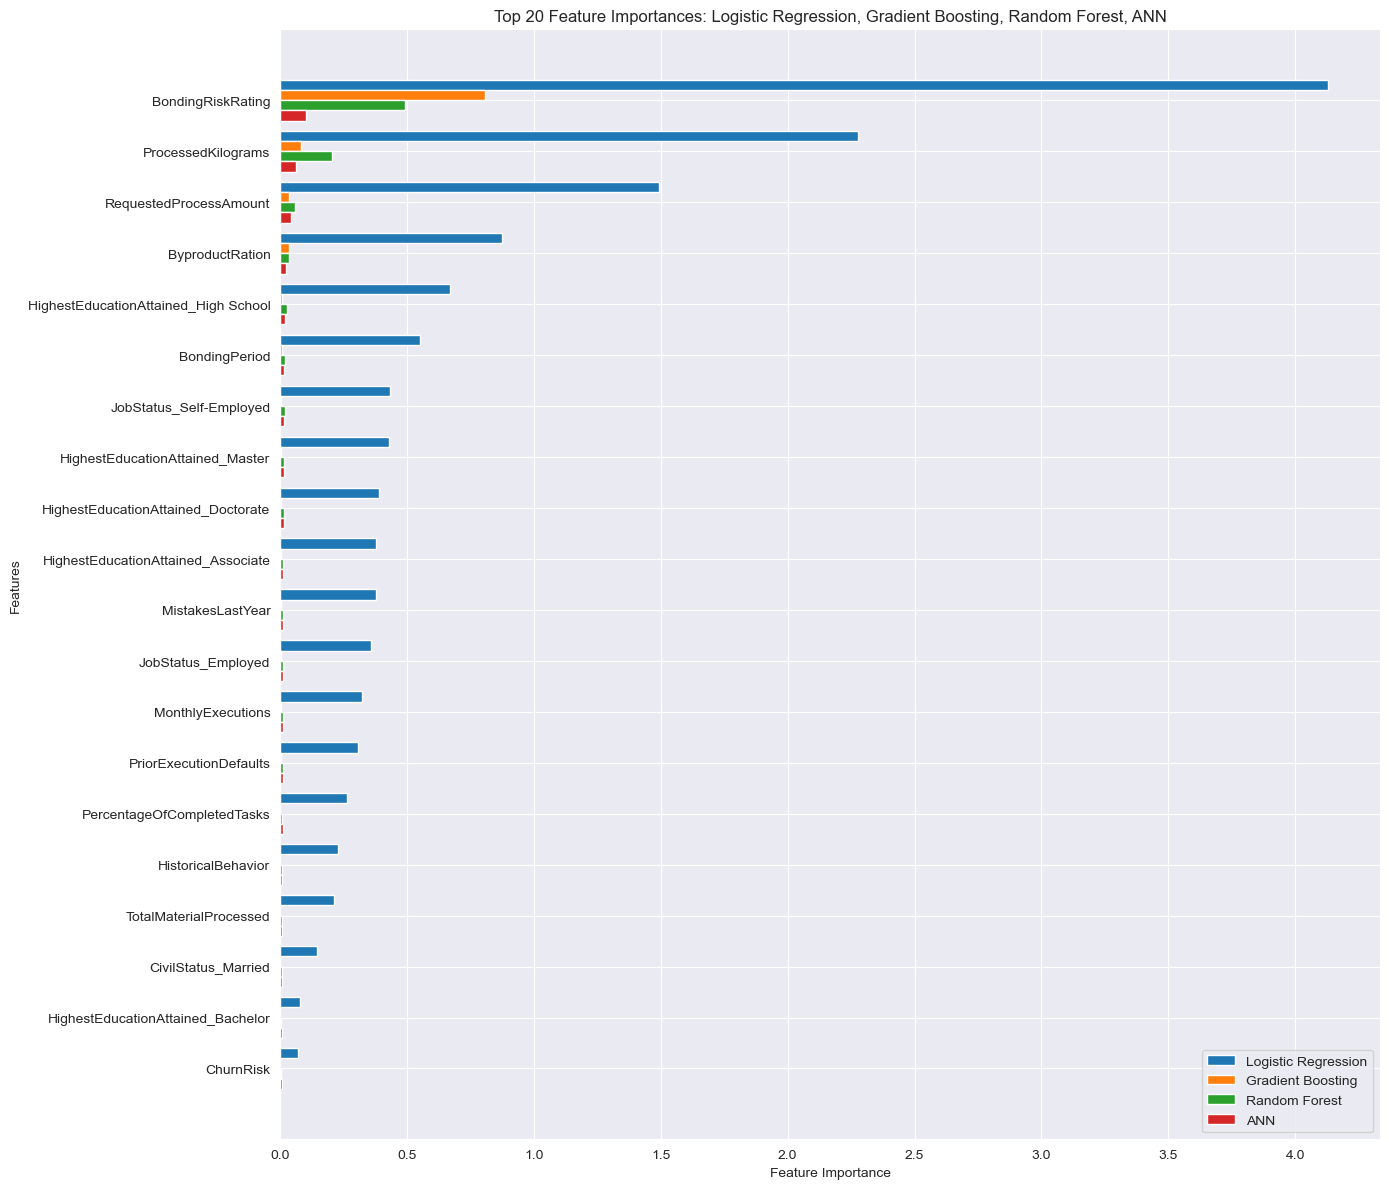

In [292]:
feature_names = preprocessor.get_feature_names_out()
cleaned_features = [feature.replace('num__', '').replace('cat__', '') for feature in feature_names]

# Feature importances for Logistic Regression
lr_importances = np.abs(best_model.coef_[0])
sorted_idx_lr = np.argsort(lr_importances)[::-1]
sorted_features_lr = np.array(cleaned_features)[sorted_idx_lr]
sorted_importance_lr = lr_importances[sorted_idx_lr]

# Feature importances for Gradient Boosting
gb_importances = best_gb_model.feature_importances_
sorted_idx_gb = np.argsort(gb_importances)[::-1]
sorted_features_gb = np.array(cleaned_features)[sorted_idx_gb]
sorted_importance_gb = gb_importances[sorted_idx_gb]

# Feature importances for Random Forest
rf_importances = best_rf_model.feature_importances_
sorted_idx_rf = np.argsort(rf_importances)[::-1]
sorted_features_rf = np.array(cleaned_features)[sorted_idx_rf]
sorted_importance_rf = rf_importances[sorted_idx_rf]

# Feature importances for ANN
ann_weights = model_ann.layers[0].get_weights()[0]
ann_importances = np.mean(np.abs(ann_weights), axis=1)
sorted_idx_ann = np.argsort(ann_importances)[::-1]
sorted_features_ann = np.array(cleaned_features)[sorted_idx_ann]
sorted_importance_ann = ann_importances[sorted_idx_ann]

# Extract the top 20 features 
top_n = 20
sorted_features = sorted_features_lr[:top_n]
importance_lr = lr_importances[sorted_idx_lr][:top_n]
importance_gb = gb_importances[sorted_idx_gb][:top_n]
importance_rf = rf_importances[sorted_idx_rf][:top_n]
importance_ann = ann_importances[sorted_idx_ann][:top_n]

# Create a bar plot for all models
x = np.arange(top_n)
plt.figure(figsize=(14, 12))
width = 0.2

# Plot the feature importances with Logistic Regression on top
plt.barh(x - 1.5 * width, importance_lr, height=0.2, label='Logistic Regression')
plt.barh(x - 0.5 * width, importance_gb, height=0.2, label='Gradient Boosting')
plt.barh(x + 0.5 * width, importance_rf, height=0.2, label='Random Forest')
plt.barh(x + 1.5 * width, importance_ann[:top_n], height=0.2, label='ANN')

# Add feature names to the y-axis
plt.yticks(x, sorted_features, rotation=0)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Feature Importances: Logistic Regression, Gradient Boosting, Random Forest, ANN')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Here we compare the feature importance from the tuned models and the first dense layer of the ANN. `BondingRiskRating` is the undisputed winner: this isn't surprising at all as it had a very high correlation (-0.77) with the target variable. The same goes for `ProcessedKilograms`. <br>
Logistic Regression is the model with the broadest use of features due to its inheritant nature as a linear model, thus considering all features as part of the linear combination that predicts the target variable. Even features with weaker correlations to `BondingSuccessful` still receive a weight because they contribute to the *accuracy* prediction.

In [293]:
from IPython.display import display

# List of models, their predictions, and names
models = [
    ("Logistic Regression", y_pred_lr, None),
    ("Tuned Logistic Regression", best_model.predict(X_test), running_time_lr_tuned),
    ("Random Forest", y_pred_rf, None),
    ("Tuned Random Forest", best_rf_model.predict(X_test), running_time_rf_tuned),
    ("Gradient Boosting", y_pred_gb, None),
    ("Tuned Gradient Boosting", best_gb_model.predict(X_test), running_time_gb_tuned),
    ("Artificial Neural Network", y_pred_art, running_time_ann)
]

# Initialize a list to store results
results = []

# Loop through models and compute metrics
for model_name, predictions, running_time in models:
    report = classification_report(y_test, predictions, output_dict=True)
    
    # Append metrics for this model
    results.append({
        "Model": model_name,
        "Accuracy": round(report["accuracy"] * 100, 2),
        "0.0 Precision": round(report["0.0"]["precision"] * 100, 2),
        "0.0 Recall": round(report["0.0"]["recall"] * 100, 2),
        "0.0 F1": round(report["0.0"]["f1-score"] * 100, 2),
        "1.0 Precision": round(report["1.0"]["precision"] * 100, 2),
        "1.0 Recall": round(report["1.0"]["recall"] * 100, 2),
        "1.0 F1": round(report["1.0"]["f1-score"] * 100, 2),
        "Running Time (s)": running_time,  # Add running time
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
display(results_df)

Model  Accuracy  0.0 Precision  0.0 Recall  0.0 F1  \
0        Logistic Regression     97.40          97.08       98.71   97.89   
1  Tuned Logistic Regression     97.45          97.09       98.78   97.93   
2              Random Forest     96.98          97.28       97.79   97.54   
3        Tuned Random Forest     97.12          97.07       98.25   97.66   
4          Gradient Boosting     97.73          98.10       98.17   98.14   
5    Tuned Gradient Boosting     98.19          98.41       98.63   98.52   
6  Artificial Neural Network     97.45          97.30       98.56   97.92   

   1.0 Precision  1.0 Recall  1.0 F1  Running Time (s)  
0          97.92       95.35   96.62               NaN  
1          98.04       95.35   96.68          3.794615  
2          96.51       95.71   96.11               NaN  
3          97.21       95.35   96.27         67.471693  
4          97.14       97.02   97.08               NaN  
5          97.85       97.50   97.67         62.478008  
6          97.69       95.71   96.69          5.655025

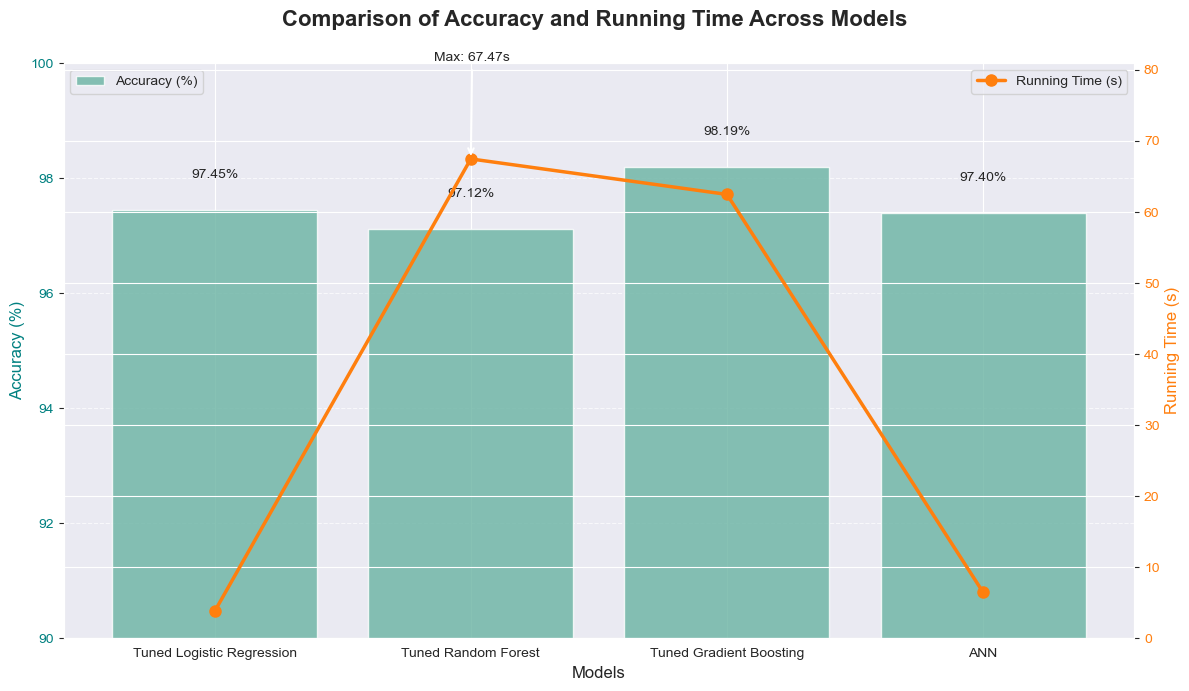

In [284]:
models = ['Tuned Logistic Regression', 'Tuned Random Forest', 'Tuned Gradient Boosting', 'ANN']
accuracy_scores = [
    accuracy_score(y_test, y_pred_lr_tuned) * 100,
    accuracy_score(y_test, y_pred_rf_tuned) * 100,
    accuracy_score(y_test, y_pred_gb_tuned) * 100,
    test_accuracy * 100  # ANN accuracy from evaluation
]
running_times = [
    running_time_lr_tuned,
    running_time_rf_tuned,
    running_time_gb_tuned,
    running_time_ann  # ANN running time
]

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(12, 7))

# Bar plot for accuracy scores
bars = ax1.bar(models, accuracy_scores, color='#69b3a2', alpha=0.8, label='Accuracy (%)', zorder=2)
ax1.set_xlabel('Models', fontsize=12)
ax1.set_ylabel('Accuracy (%)', fontsize=12, color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.set_ylim(90, 100)  # Adjust as needed
ax1.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.2f}%', ha='center', va='bottom', fontsize=10)

# Line plot for running times
ax2 = ax1.twinx()
line = ax2.plot(models, running_times, color='#ff7f0e', marker='o', label='Running Time (s)', linewidth=2.5, markersize=8, zorder=3)
ax2.set_ylabel('Running Time (s)', fontsize=12, color='#ff7f0e')
ax2.tick_params(axis='y', labelcolor='#ff7f0e')
ax2.set_ylim(0, max(running_times) * 1.2)  # Adjust y-axis limit dynamically

# Highlight the highest running time with annotation
max_time_index = np.argmax(running_times)
ax2.annotate(
    f'Max: {running_times[max_time_index]:.2f}s',
    xy=(models[max_time_index], running_times[max_time_index]),
    xytext=(max_time_index, running_times[max_time_index] + 3),
    textcoords='offset points',
    arrowprops=dict(facecolor='gray', arrowstyle='->', lw=1.5),
    fontsize=10,
    ha='center'
)

# Add legends and title
fig.suptitle('Comparison of Accuracy and Running Time Across Models', fontsize=16, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

This analysis underlines the performance of a number of machine learning models on this dataset, even in their base versions. That result underlines how good the data is and how appropriate the preprocessing steps taken are. The dataset retained its richness and variability by keeping outliers and balancing the target variable, thus enabling the models to capture meaningful patterns without overfitting. This also ensured the dataset remained large enough—a very critical factor while building robust models that can generalize well.

The ANN performed very well, mostly managing to reach the accuracy achieved with more straightforward models, including logistic regression and methods involving trees. However, considering complexity and low interpretability, it is less desirable for a given problem whereby one can understand insight from features importance. The remaining models, especially Gradient Boosting, could achieve very good performance and still be able to track which features are important because of their nature and thus be much more practical.

Among the different models, the best performance in terms of accuracy and F1 score was obtained with Tuned Gradient Boosting. Since it can balance precision and recall of both classes more coherently than others, this model is the most reliable to be deployed. Again, this success speaks to the power of ensemble methods in bringing out the strengths from both the individual features and the complex interactions.

This project therefore serves as an excellent example of how effective preprocessing, combined with the choice of a wide range of different modeling approaches, can yield really powerful predictive systems. Advanced models like ANN have their place, but often simpler better-tuned models offer an appealing combination of performance, interpretability, and practical utility—as was shown by the dominance of Gradient Boosting in this analysis.